In [ ]:
import statsmodels
import pandas as pd
import numpy as np 
import jsonlines
import glob
import matplotlib.pyplot as plt
import seaborn as sns 
import ast

from statsmodels.sandbox.stats.runs import mcnemar as mcnemar_test

model_mapping = {
    "gpt4o-mini" : "gpt-4o-mini", 
    "gemma": "google__gemma-2b",
    "mistral-7b": "mistralai__Mistral-7B-Instruct-v0.3",
}

datasets = ["boolq", "sciq", "mmlu"]

base_path = "~/Dialect_Bias/data/"

oblig_rule_descrip = "data/dialect_oblig_rules.csv"
oblig_rule_json = "data/attestA_rules.json"

In [18]:
def clean_executed_rules(x): 
    rule_dict = ast.literal_eval(x)
    return [v["type"] for _ , v in rule_dict.items()] if x else []

def get_relevant_info(rules_df, metric="acc", rules_executed=False): 
    rules_df["id"] = rules_df["doc"].apply(lambda d: d["id"])
    rules_df["rule_transform"] = rules_df["doc"].apply(lambda d: d["rule_transform"])
    rules_df["transformed_text"] = rules_df["doc"].apply(lambda d: d["transformed_text"])
    # for ease of data manipulation, rename exact matches into accuracy
    rules_df["acc"] = rules_df[metric]
    rules_df_slice = rules_df[["id", "transformed_text", "rule_transform", "acc" ]]

    if rules_executed: 
        rules_df["rules_executed"] = rules_df["doc"].apply(lambda d: d["rules_executed"])
        rules_df["rules_executed_list"] = rules_df["rules_executed"].apply(clean_executed_rules)
        rules_df_slice = rules_df[["id", "transformed_text", "rule_transform", "rules_executed_list", "acc" ]]

    return rules_df_slice

def get_baseline_info(subset_df,  metric="acc"): 
    subset_df["id"] = subset_df["doc"].apply(lambda d: d["id"])
    subset_df["orig_question"] = subset_df["doc"].apply(lambda d: d["question"])
    subset_df["acc"] = subset_df[metric]
    subset_df_slice = subset_df[["id", "orig_question", "acc"]]
    return subset_df_slice

def merge_transform_and_baseline(dialect_slice, baseline_slice, transform_suffix="dialect"): 
    combined_df = pd.merge(dialect_slice, baseline_slice, on="id", how="left", suffixes=(f"_{transform_suffix}", "_orig"))
    
    return combined_df

def plot_rules(combined_df, title="BoolQ", topk=15, threshold=50, metric_diff="Accuracy Difference"):
    # rules_slice = get_relevant_info(rules_df)
    # subset_slice = get_baseline_info(subset_df)
    
    cat_order = combined_df.groupby(['rule_transform'])[metric_diff].mean().sort_values().index
    # only consider rules applied to at least least 5% of data
    # threshold = len(subset_slice)/20

    applied_counts = combined_df.groupby(['rule_transform'])["id"].count().reset_index()
    over_50_counts = applied_counts[applied_counts["id"] > threshold]

    big_sample_df = combined_df[combined_df["rule_transform"].isin(over_50_counts["rule_transform"])]
    big_sample_diffs = big_sample_df.groupby(['rule_transform'])[metric_diff].mean().sort_values().index
    top_k = big_sample_diffs[:topk]

    big_sample_df = big_sample_df[big_sample_df["rule_transform"].isin(top_k)]
    if topk == 10: 
        height = 4
        aspect = 1.75
    else: 
        height = 6
        aspect = 1.25

    cp = sns.catplot(kind="bar", data = big_sample_df, y="rule_transform", order=top_k, x=metric_diff, errorbar=("ci", 95), height=height, aspect=aspect)

    cp.tick_params(axis='x', rotation=90)
    # cp.fig.suptitle('BoolQ Accuracy Difference of Rule Transform Compared to Original', y=1.05)
    cp.fig.suptitle(title, y=1.05)

def combine_orig_and_transform(orig_df, transformed_df, model="gemma", transform_suffix="dialect", metric_diff="Accuracy Difference", rules_executed=False ):
    metric = "exact_match" if model == "gpt4o-mini" else "acc"
    print(metric)
    transform_slice = get_relevant_info(transformed_df, metric=metric, rules_executed=rules_executed)
    subset_slice = get_baseline_info(orig_df, metric=metric)
    
    combined_df = merge_transform_and_baseline(transform_slice, subset_slice, transform_suffix=transform_suffix)
    combined_df[metric_diff] = combined_df[f"acc_{transform_suffix}"] - combined_df[f"acc_orig"] 
    return combined_df

    
def load_files_matching(search_pattern): 
    file_list = glob.glob(search_pattern)
    df_list = []

    for fp in file_list: 
        df = pd.read_json(fp, lines=True)
        df_list.append(df)
    return pd.concat(df_list)


# Analyze Rules independently 

In [3]:
df_list = []

for model in model_mapping: 
    for dataset in datasets: 
        print("model", model)
        print("dataset", dataset)
        if dataset == "mmlu": 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"

            # dialect_df = load_files_matching(dialects_log_path)
            subset_df = load_files_matching(subset_log_path)
            rules_df = load_files_matching(rules_log_path)
        else: 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"

            subset_df = pd.read_json(subset_log_path, lines=True)
            # dialect_df = pd.read_json(dialects_log_path, lines=True)
            rules_df = pd.read_json(rules_log_path, lines=True)

        combined_df = combine_orig_and_transform(subset_df, rules_df, model=model, transform_suffix="rule")
        combined_df["dataset"] = dataset
        combined_df["model"] = model 
        df_list.append(combined_df)

rule_combined_df = pd.concat(df_list)

model gpt4o-mini
dataset boolq
exact_match
model gpt4o-mini
dataset sciq
exact_match
model gpt4o-mini
dataset mmlu
exact_match
model gemma
dataset boolq
acc
model gemma
dataset sciq
acc
model gemma
dataset mmlu
acc
model mistral-7b
dataset boolq
acc
model mistral-7b
dataset sciq
acc
model mistral-7b
dataset mmlu
acc


In [ ]:
from statsmodels.sandbox.stats.runs import mcnemar as mcnemar_test

rules_by_acc_diff = rule_combined_df.groupby(['rule_transform'])["Accuracy Difference"].mean().sort_values().index
acc_diffs = rule_combined_df.groupby(['rule_transform'])["Accuracy Difference"].mean().sort_values().values

data_list = [] 
for r, diff in zip(rules_by_acc_diff, acc_diffs):
    rule_slice = rule_combined_df[rule_combined_df["rule_transform"] == r ] 
    # based on internet, use when over 25 differing 
    test_res = mcnemar_test(rule_slice["acc_orig"], rule_slice["acc_rule"], exact=False, correction=True)
    count = len(rule_slice["acc_orig"])/len(model_mapping)
    # test_res = mcnemar_test(rule_slice["acc_orig"], rule_slice["acc_rule"])
    data_list.append([r, diff, test_res[1], test_res[0], count])

stats_df = pd.DataFrame(data_list, columns=["Grammar Rule", "Accuracy Difference", "pvalue", "Statistic", "Applied Count"]) 

In [135]:
stats_df

,Grammar Rule,Accuracy Difference,pvalue,Statistic,Applied Count
0,negative_inversion,-0.111111,7.363827e-02,3.200000,15.0
1,existential_it,-0.031103,9.923637e-12,46.343496,1629.0
2,conditional_were_was,-0.030303,1.336144e-01,2.250000,44.0
3,invariant_tag_can_or_not,-0.030150,4.232013e-18,75.210079,3759.0
4,give_passive,-0.026816,1.792639e-05,18.397810,895.0
...,...,...,...,...,...
69,drop_aux_be_progressive,0.010455,8.627557e-02,2.942529,542.0
70,dont,0.012821,1.000000e+00,0.000000,26.0
71,regularized_reflexives,0.019841,2.278000e-01,1.454545,84.0
72,quotative_like,0.027778,2.888444e-01,1.125000,48.0


In [51]:
stats_df.to_csv("data/mcnemar_rule_stats_by_diff.csv", index=False)

In [189]:
top_25_rules = stats_df[1:26]
top_25_rules

,Grammar Rule,Accuracy Difference,pvalue,Statistic,Applied Count
1,give_passive,-0.029350,1.792639e-05,18.397810,895.0
2,fronting_pobj,-0.024237,2.497387e-46,204.226849,14760.0
3,conditional_were_was,-0.023810,1.336144e-01,2.250000,44.0
4,existential_it,-0.018927,9.923637e-12,46.343496,1629.0
5,preposition_chopping,-0.013986,3.210620e-01,0.984615,377.0
6,completive_finish,-0.013084,2.429711e-04,13.465649,739.0
7,existential_got,-0.012739,8.622346e-03,6.899425,1525.0
8,drop_aux_wh,-0.011078,4.688920e-03,7.995676,10926.0
9,yall,-0.011029,1.562136e-03,10.003846,1377.0
10,drop_aux_yn,-0.010928,2.898876e-06,21.882353,12960.0


In [371]:
rule_in_focus = "existential_it"
dataset = "boolq"
model = "gpt4o-mini"

acc_diff_rule = rule_combined_df[(rule_combined_df["rule_transform"] == rule_in_focus) & (rule_combined_df["Accuracy Difference"] == -1)]
acc_diff_rule = acc_diff_rule[acc_diff_rule["dataset"] == dataset]
acc_diff_rule = acc_diff_rule[acc_diff_rule["model"]==model]
acc_diff_rule.sample(10)

,id,transformed_text,rule_transform,acc_rule,orig_question,acc_orig,Accuracy Difference,dataset,model
31891,6826,is it really a letters to juliet wall,existential_it,0,is there really a letters to juliet wall,1,-1,boolq,gpt4o-mini
31834,6428,is it stand your ground law in california,existential_it,0,is there stand your ground law in california,1,-1,boolq,gpt4o-mini
31807,6214,is it a train station in burnham-on-sea,existential_it,0,is there a train station in burnham-on-sea,1,-1,boolq,gpt4o-mini
31100,1079,will it is a 3rd series of 800 words,existential_it,0,will there be a 3rd series of 800 words,1,-1,boolq,gpt4o-mini
31856,6607,is it a sequel to fallen the movie,existential_it,0,is there a sequel to fallen the movie,1,-1,boolq,gpt4o-mini
31743,5742,is it an extra scene in infinity wat,existential_it,0,is there an extra scene in infinity wat,1,-1,boolq,gpt4o-mini
32205,9248,is it a solution to the seven bridges of konig...,existential_it,0,is there a solution to the seven bridges of ko...,1,-1,boolq,gpt4o-mini
32017,7642,is it a correct way to hang toilet paper,existential_it,0,is there a correct way to hang toilet paper,1,-1,boolq,gpt4o-mini
31987,7441,is it a county general hospital in chicago,existential_it,0,is there a county general hospital in chicago,1,-1,boolq,gpt4o-mini
31426,3472,is it a right way to put on toilet paper,existential_it,0,is there a right way to put on toilet paper,1,-1,boolq,gpt4o-mini


# add ewave descriptions 

In [136]:
descriptions = pd.read_csv(oblig_rule_descrip)
# stats_df= pd.read_csv("data/mcnemar_rule_stats_by_diff.csv")

In [137]:
descrip_aug = descriptions[descriptions["rule_name"].isin(stats_df["Grammar Rule"])]
dialect_groups = descrip_aug.groupby('rule_name')['abbr'].apply(list).reset_index()
descrip_aug_unique = descrip_aug.drop_duplicates(subset=["rule_name"])[["parameter_name", "parameter_description", "rule_name"]]
rule_metadata = dialect_groups.merge(descrip_aug_unique, on="rule_name")
rule_metadata = rule_metadata.rename(columns = {"abbr": "Dialect", "parameter_name": "Rule Definition", "parameter_description": "Rule Example"})

In [138]:
rule_table = stats_df.merge(rule_metadata, left_on="Grammar Rule", right_on="rule_name").drop(columns="rule_name")
# top_25_rule_table = rule_table[rule_table["Grammar Rule"].isin(top_25_rules["Grammar Rule"])]


In [139]:
rule_table

,Grammar Rule,Accuracy Difference,pvalue,Statistic,Applied Count,Dialect,Rule Definition,Rule Example
0,negative_inversion,-0.111111,7.363827e-02,3.200000,15.0,[SEAmE],“Negative inversion”,Didnʼt nobody show up ‘Nobody showed up’; Ther...
1,existential_it,-0.031103,9.923637e-12,46.343496,1629.0,"[UAAVE, AppE, CollSgE]",Variant forms of dummy subject there in existe...,They is something bad wrong with her; Itʼs a n...
2,conditional_were_was,-0.030303,1.336144e-01,2.250000,44.0,"[UAAVE, AppE, SEAmE, IndE]",Was for conditional were,If I was you
3,invariant_tag_can_or_not,-0.030150,4.232013e-18,75.210079,3759.0,[CollSgE],Invariant tag can or not?,"I want to go home, can or not? ‘Can I go home?..."
4,give_passive,-0.026816,1.792639e-05,18.397810,895.0,[CollSgE],Give passive: NP1 (patient) + give + NP2 (agen...,John give his boss scold ‘John was scolded by ...
...,...,...,...,...,...,...,...,...
67,drop_aux_be_progressive,0.010455,8.627557e-02,2.942529,542.0,"[UAAVE, CollSgE]",Deletion of auxiliary be: before progressive,So you Ø always thinking about where where you...
68,dont,0.012821,1.000000e+00,0.000000,26.0,"[UAAVE, SEAmE]",Invariant don’t for all persons in the present...,He donʼt like me.
69,regularized_reflexives,0.019841,2.278000e-01,1.454545,84.0,"[UAAVE, SEAmE]",Regularized reflexives paradigm,"hisself, theirselves/theirself"
70,quotative_like,0.027778,2.888444e-01,1.125000,48.0,[IndE],Like as a quotative particle,And she was like “What do you mean?”


In [28]:
# top_25_rule_table.to_csv("data/top_25_rule_by_sig.csv", index=False)
rule_table.to_csv("data/full_rule_by_diff_sae_correct.csv", index=False)

# select top 3 - 5 rules for each dialect

order by accuracy difference, and then filter by pval less than .01

In [140]:
# rule_table = pd.read_csv("data/full_rule_by_diff.csv")
# rule_table = pd.read_csv("data/full_rule_by_sig.csv")
# rule_table["Dialect"] = rule_table["Dialect"].apply(ast.literal_eval)


# threshold = 28036*.05
threshold = 50

sig_rules = rule_table[rule_table["Applied Count"] > threshold]
sig_rules = sig_rules[sig_rules["pvalue"] < .05]
sig_rules


,Grammar Rule,Accuracy Difference,pvalue,Statistic,Applied Count,Dialect,Rule Definition,Rule Example
1,existential_it,-0.031103,9.923637e-12,46.343496,1629.0,"[UAAVE, AppE, CollSgE]",Variant forms of dummy subject there in existe...,They is something bad wrong with her; Itʼs a n...
3,invariant_tag_can_or_not,-0.030150,4.232013e-18,75.210079,3759.0,[CollSgE],Invariant tag can or not?,"I want to go home, can or not? ‘Can I go home?..."
4,give_passive,-0.026816,1.792639e-05,18.397810,895.0,[CollSgE],Give passive: NP1 (patient) + give + NP2 (agen...,John give his boss scold ‘John was scolded by ...
5,invariant_tag_non_concord,-0.022524,1.506565e-11,45.525605,3759.0,"[IndE, CollSgE]",Invariant non-concord tags,"They had them in their hair, innit?"
6,completive_finish,-0.019396,2.429711e-04,13.465649,739.0,[CollSgE],Finish-derived completive markers,Wakum gaden blong mifala finis ‘I have complet...
7,fronting_pobj,-0.017706,2.497387e-46,204.226849,14760.0,[IndE],Other possibilities for fronting than StE,To my sister sometime I speak English.
8,yall,-0.012588,1.562136e-03,10.003846,1377.0,"[UAAVE, AppE, SEAmE]",Forms or phrases for the second person plural ...,youse; yʼall; aayʼ; yufela; you…together; all ...
10,null_prepositions,-0.012175,1.076860e-47,210.484513,28036.0,[CollSgE],Omission of StE prepositions,He came out Ø hospital; She went Ø town; We’r...
11,aint_be,-0.011338,2.881873e-02,4.778409,882.0,"[UAAVE, AppE, SEAmE]",Ain’t as the negated form of be,"Theyʼre all in there, ainʼt they?"
12,existential_got,-0.010929,8.622346e-03,6.899425,1525.0,[CollSgE],Existentials with forms of get,E got some sand there ‘There is some sand’; Ov...


In [141]:
rules_shared_dialect_slice = sig_rules[(sig_rules["Dialect"].apply(lambda x: len(x) > 1)) & (sig_rules["Accuracy Difference"] < 0)]
rules_shared_dialect_slice

,Grammar Rule,Accuracy Difference,pvalue,Statistic,Applied Count,Dialect,Rule Definition,Rule Example
1,existential_it,-0.031103,9.923637e-12,46.343496,1629.0,"[UAAVE, AppE, CollSgE]",Variant forms of dummy subject there in existe...,They is something bad wrong with her; Itʼs a n...
5,invariant_tag_non_concord,-0.022524,1.506565e-11,45.525605,3759.0,"[IndE, CollSgE]",Invariant non-concord tags,"They had them in their hair, innit?"
8,yall,-0.012588,1.562136e-03,10.003846,1377.0,"[UAAVE, AppE, SEAmE]",Forms or phrases for the second person plural ...,youse; yʼall; aayʼ; yufela; you…together; all ...
11,aint_be,-0.011338,2.881873e-02,4.778409,882.0,"[UAAVE, AppE, SEAmE]",Ain’t as the negated form of be,"Theyʼre all in there, ainʼt they?"
14,drop_copula_be_NP,-0.009643,9.517817e-07,24.023275,5911.0,"[UAAVE, CollSgE]",Deletion of copula be: before NPs,He Ø a good teacher.
20,drop_aux_yn,-0.004810,2.898876e-06,21.882353,12960.0,"[IndE, CollSgE]",No inversion/no auxiliaries in main clause yes...,You get the point? You liked India?
25,remove_det_indefinite,-0.003343,5.884992e-03,7.585185,9671.0,"[IndE, CollSgE]",Use of zero article where StE has indefinite a...,"Then he thought, what about getting Ø girl [to..."
26,progressives,-0.003333,1.795114e-03,9.748067,12400.0,"[SEAmE, IndE]",Wider range of uses of progressive be + V-ing ...,Iʼm liking this; What are you wanting?
32,drop_aux_wh,-0.002654,4.688920e-03,7.995676,10926.0,"[IndE, CollSgE]",No inversion/no auxiliaries in wh-questions,What you doing? What he wants?


In [142]:
rules_shared_dialect_slice["Grammar Rule"].tolist()

['existential_it',
 'invariant_tag_non_concord',
 'yall',
 'aint_be',
 'drop_copula_be_NP',
 'drop_aux_yn',
 'remove_det_indefinite',
 'progressives',
 'drop_aux_wh']

In [33]:
sig_rules.to_csv("data/sig_rules_by_diff_sae_correct.csv")

In [78]:
# exclude chicano from analysis as it only has one rule 

# Create a new dataframe to store rules by dialect
rules_by_dialect = pd.DataFrame(columns=['Dialect', 'Grammar Rule', 'Accuracy Difference', 'pvalue', 'Applied Count'])

# Iterate through each row
# for _, row in sig_rules.iterrows():
for _, row in rule_table.iterrows():
    for dialect in row['Dialect']:
        rules_by_dialect = pd.concat([rules_by_dialect, pd.DataFrame({
            'Dialect': [dialect],
            'Grammar Rule': [row['Grammar Rule']],
            'Accuracy Difference': [row['Accuracy Difference']],
            'pvalue': [row['pvalue']],
            'Applied Count': [row['Applied Count']]
        })], ignore_index=True)

# Sort by Dialect and pvalue
# rules_by_dialect = rules_by_dialect.sort_values(['Dialect', 'Applied Count'], ascending=False)
rules_by_dialect = rules_by_dialect.sort_values(['Dialect', 'pvalue'], ascending=True)

# Optional: You could group by dialect to get a summary
dialect_summary = rules_by_dialect.groupby('Dialect').size().reset_index(name='Rule Count')

rules_by_dialect

/tmp/ipykernel_2571431/167881605.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rules_by_dialect = pd.concat([rules_by_dialect, pd.DataFrame({


,Dialect,Grammar Rule,Accuracy Difference,pvalue,Applied Count
80,AppE,me_coordinate_subjects,0.000000,0.000000e+00,4.0
2,AppE,existential_it,-0.031103,9.923637e-12,1629.0
15,AppE,yall,-0.012588,1.562136e-03,1377.0
21,AppE,aint_be,-0.011338,2.881873e-02,882.0
64,AppE,plural_interrogative,-0.002067,6.276282e-02,6289.0
...,...,...,...,...,...
88,UAAVE,regularized_plurals,0.000749,7.915276e-01,2224.0
92,UAAVE,drop_copula_be_locative,0.000818,9.266524e-01,815.0
74,UAAVE,finna_future,-0.000498,1.000000e+00,669.0
86,UAAVE,drop_copula_be_AP,0.000149,1.000000e+00,2232.0


In [79]:
dialect_abbrvs = rules_by_dialect["Dialect"].unique()

top_3_rule_dfs = [] 

for d in dialect_abbrvs:
    dialect_slice = rules_by_dialect[rules_by_dialect["Dialect"] == d]
    negative_val = dialect_slice[dialect_slice["Accuracy Difference"] < 0]
    top_3 = negative_val.head(4)
    top_3_rule_dfs.append(top_3)

top_rules_by_dialect = pd.concat(top_3_rule_dfs)
top_rules_by_dialect

,Dialect,Grammar Rule,Accuracy Difference,pvalue,Applied Count
2,AppE,existential_it,-0.031103,9.923637e-12,1629.0
15,AppE,yall,-0.012588,1.562136e-03,1377.0
21,AppE,aint_be,-0.011338,2.881873e-02,882.0
64,AppE,plural_interrogative,-0.002067,6.276282e-02,6289.0
34,ChcE,negative_concord,-0.006972,1.036146e-01,1004.0
19,CollSgE,null_prepositions,-0.012175,1.076860e-47,28036.0
8,CollSgE,invariant_tag_can_or_not,-0.030150,4.232013e-18,3759.0
3,CollSgE,existential_it,-0.031103,9.923637e-12,1629.0
11,CollSgE,invariant_tag_non_concord,-0.022524,1.506565e-11,3759.0
13,IndE,fronting_pobj,-0.017706,2.497387e-46,14760.0


In [235]:
top_rules_by_dialect.to_csv("data/top_4_rule_by_dialect.csv")

# all dialect rules

In [5]:
top_rules_by_dialect = pd.read_csv("data/top_4_rule_by_dialect.csv")

In [4]:
df_list = []

for model in model_mapping: 
    for dataset in datasets: 
        print("model", model)
        print("dataset", dataset)
        if dataset == "mmlu": 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"

            dialect_df = load_files_matching(dialects_log_path)
            subset_df = load_files_matching(subset_log_path)
             # rules_df = load_files_matching(rules_log_path)
        else: 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"

            subset_df = pd.read_json(subset_log_path, lines=True)
            dialect_df = pd.read_json(dialects_log_path, lines=True)
            # rules_df = pd.read_json(rules_log_path, lines=True)

        combined_df = combine_orig_and_transform(subset_df, dialect_df, model=model, transform_suffix="dialect", rules_executed=True)
        combined_df["dataset"] = dataset
        combined_df["model"] = model 
        df_list.append(combined_df)

dialect_combined_df = pd.concat(df_list)

model gpt4o-mini
dataset boolq
exact_match
model gpt4o-mini
dataset sciq
exact_match
model gpt4o-mini
dataset mmlu
exact_match
model gemma
dataset boolq
acc
model gemma
dataset sciq
acc
model gemma
dataset mmlu
acc
model mistral-7b
dataset boolq
acc
model mistral-7b
dataset sciq
acc
model mistral-7b
dataset mmlu
acc


In [5]:
dialect_mapping = {
    "AfricanAmericanVernacular": "UAAVE",
    "SoutheastAmericanEnclaveDialect" : "SEAmE", 
    "AppalachianDialect": "AppE", 
    "IndianDialect": "IndE", 
    "ColloquialSingaporeDialect": "CollSgE", 
    "ChicanoDialect": "ChcE",
    
    # oops somehow data file has two naming conventions, standardize
    "Urban African American Vernacular English": "UAAVE",
    "Southeast American enclave dialects" : "SEAmE", 
    "Appalachian English": "AppE", 
    "Indian English": "IndE", 
    "Colloquial Singapore English (Singlish)": "CollSgE",
    "Chicano English": "ChcE",
}


dialect_combined_df["Dialect"] = dialect_combined_df["rule_transform"].apply(lambda x: dialect_mapping[x])
dialect_combined_df = dialect_combined_df[~(dialect_combined_df["rules_executed_list"].apply(lambda l: len(l) == 0))]

In [15]:
chicano_ids = filtered_dialect_combined_df[(filtered_dialect_combined_df["dataset"] == "boolq") & (filtered_dialect_combined_df["Dialect"] == "ChcE")]["id"].unique()

In [ ]:
# Save the array to a .npy file
np.save('data/ChcE_ids.npy', chicano_ids)

# Load the array from the .npy file
loaded_arr = np.load('data/ChcE_ids.npy')

loaded_arr

array([   1,    5,    6, ..., 9336, 9337, 9346])

## fill in with original accuracies where doesn't exist 

In [77]:
df_list = []

for model in model_mapping: 
    for dataset in datasets: 
        print("model", model)
        print("dataset", dataset)
        if dataset == "mmlu": 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"

            dialect_df = load_files_matching(dialects_log_path)
            subset_df = load_files_matching(subset_log_path)
             # rules_df = load_files_matching(rules_log_path)
        else: 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"

            subset_df = pd.read_json(subset_log_path, lines=True)
            dialect_df = pd.read_json(dialects_log_path, lines=True)
            # rules_df = pd.read_json(rules_log_path, lines=True)
        # combined_df = fill_in_unperturbed_dialect(subset_df, dialect_df, model=model)
        metric = "exact_match" if model == "gpt4o-mini" else "acc"
        orig_df = get_baseline_info(subset_df, metric=metric).copy()
        orig_df["dataset"] = dataset
        orig_df["model"] = model 
        df_list.append(orig_df)

orig_combined_df = pd.concat(df_list)

model gpt4o-mini
dataset boolq
model gpt4o-mini
dataset sciq
model gpt4o-mini
dataset mmlu
model gemma
dataset boolq
model gemma
dataset sciq
model gemma
dataset mmlu
model mistral-7b
dataset boolq
model mistral-7b
dataset sciq
model mistral-7b
dataset mmlu


In [79]:

# Method 1: Using merge with indicator and filtering
def filter_non_matching_rows(orig_df, dialect_df, key_columns=['model', 'id', 'dataset']):
    # Merge with indicator to identify matching rows
    merged = pd.merge(
        orig_df, 
        dialect_df[key_columns], 
        on=key_columns, 
        how='left',
        indicator=True
    )
    # Keep only rows from df1 that don't appear in df2
    non_matching = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    return non_matching

In [80]:
dialects = dialect_combined_df["Dialect"].unique()

dialect_slices = [] 

for d in dialects: 
    dialect_slice = dialect_combined_df[dialect_combined_df["Dialect"] == d] 
    unperturbed_rows = filter_non_matching_rows(orig_combined_df, dialect_slice)
    unperturbed_rows["acc_dialect"] = unperturbed_rows["acc"]
    unperturbed_rows["acc_orig"] = unperturbed_rows["acc"]
    unperturbed_rows["transformed_text"] = unperturbed_rows["orig_question"]
    unperturbed_rows["Dialect"] = d
    # unperturbed_rows["rules_executed_list"] = []*len(unperturbed_rows)
    unperturbed_rows["Accuracy Difference"] = 0
    
    filled_in_dialect_slice = pd.concat([dialect_slice, unperturbed_rows])
    dialect_slices.append(filled_in_dialect_slice)

dialect_empty_combined_df = pd.concat(dialect_slices)



In [81]:
 
metric_diff = "acc_dialect"

grouped_df = dialect_combined_df.groupby(["dataset", "model", 'Dialect'])[metric_diff].mean().reset_index()
applied_only_pivoted_df = grouped_df.pivot_table(
    index='Dialect',
    columns=['dataset', 'model'],
    values=metric_diff
)


# applied_only_pivoted_df.to_csv("data/dialect_accuracy_only_applied.csv")
applied_only_pivoted_df

dataset     boolq                            mmlu                        \
model       gemma gpt4o-mini mistral-7b     gemma gpt4o-mini mistral-7b   
Dialect                                                                   
AppE     0.708996   0.856594   0.831965  0.348813   0.686989   0.595540   
ChcE     0.717998   0.871718   0.845186  0.328854   0.654312   0.569256   
CollSgE  0.665344   0.845651   0.797812  0.341457   0.686876   0.585171   
IndE     0.680828   0.853664   0.811501  0.346633   0.688160   0.593561   
SEAmE    0.691908   0.858333   0.832971  0.339855   0.698026   0.594657   
UAAVE    0.676876   0.858323   0.826154  0.341978   0.692273   0.595421   

dataset      sciq                        
model       gemma gpt4o-mini mistral-7b  
Dialect                                  
AppE     0.934363   0.972160   0.965454  
ChcE     0.937803   0.976185   0.966474  
CollSgE  0.917196   0.961261   0.947002  
IndE     0.927263   0.965265   0.957957  
SEAmE    0.935160   0.972073   0.962999  
UAAVE    0.932984   0.970205   0.961031

In [ ]:
count_grouped_df = dialect_combined_df.groupby(["dataset", 'Dialect'])[metric_diff].count()//3
count_grouped_df = count_grouped_df.reset_index()
applied_only_count_df = count_grouped_df.pivot_table(
    index='Dialect',
    columns=['dataset'],
    values=metric_diff
)


# applied_only_count_df.to_csv("data/dialect_accuracy_only_applied_counts.csv")

applied_only_count_df

dataset,boolq,mmlu,sciq
Dialect,,,
AppE,5725.0,9776.0,9842.0
ChcE,3656.0,6772.0,4325.0
CollSgE,9323.0,11612.0,11642.0
IndE,9321.0,11554.0,11631.0
SEAmE,8280.0,11193.0,11351.0
UAAVE,9077.0,11182.0,11445.0


In [ ]:
metric_diff = "acc_dialect"
grouped_df = dialect_empty_combined_df.groupby(["dataset", "model", 'Dialect'])[metric_diff].mean().reset_index()
pivoted_df = grouped_df.pivot_table(
    index='Dialect',
    columns=['dataset', 'model'],
    values=metric_diff
)
# pivoted_df.to_csv("data/dialect_accuracy_with_empty.csv")
# dialect_empty_combined_df.groupby(["dataset", "model", 'Dialect'])[metric_diff].count()

pivoted_df

dataset   boolq                           mmlu                           sciq  \
model     gemma gpt4o-mini mistral-7b    gemma gpt4o-mini mistral-7b    gemma   
Dialect                                                                         
AppE     9348.0     9348.0     9348.0  11672.0    11672.0    11672.0  11647.0   
ChcE     9348.0     9348.0     9348.0  11672.0    11672.0    11672.0  11647.0   
CollSgE  9348.0     9348.0     9348.0  11672.0    11672.0    11672.0  11647.0   
IndE     9348.0     9348.0     9348.0  11672.0    11672.0    11672.0  11647.0   
SEAmE    9348.0     9348.0     9348.0  11672.0    11672.0    11672.0  11647.0   
UAAVE    9348.0     9348.0     9348.0  11672.0    11672.0    11672.0  11647.0   

dataset                        
model   gpt4o-mini mistral-7b  
Dialect                        
AppE       11647.0    11647.0  
ChcE       11647.0    11647.0  
CollSgE    11647.0    11647.0  
IndE       11647.0    11647.0  
SEAmE      11647.0    11647.0  
UAAVE      11647.0    11647.0

In [12]:
only_sae_acc_empty = dialect_empty_combined_df[dialect_empty_combined_df["acc_orig"] == 1]
grouped_df = only_sae_acc_empty.groupby(["dataset", "model", 'Dialect'])[metric_diff].mean().reset_index()
only_sae_acc_empty_df = grouped_df.pivot_table(
    index='Dialect',
    columns=['dataset', 'model'],
    values=metric_diff
)


# applied_only_pivoted_df.to_csv("data/dialect_accuracy_only_applied.csv")
# only_sae_acc_empty_df.to_csv("data/dialect_sae_correct_with_empty.csv")

only_sae_acc_empty_df

NameError: name 'dialect_empty_combined_df' is not defined

In [8]:
metric_diff = "acc_dialect"

only_sae_acc_count = only_sae_acc_empty.groupby(["dataset", 'Dialect', "model"])[metric_diff].count()
only_sae_acc_count = only_sae_acc_count.reset_index()
sae_acc_empty_count_df = only_sae_acc_count.pivot_table(
    index='Dialect',
    columns=['dataset', "model"],
    values=metric_diff
)

sae_acc_empty_count_df

NameError: name 'only_sae_acc_empty' is not defined

In [14]:
only_sae_acc = filtered_dialect_combined_df[filtered_dialect_combined_df["acc_orig"] == 1]
grouped_df = only_sae_acc.groupby(["dataset", "model", 'Dialect'])[metric_diff].mean().reset_index()
only_sae_acc_df = grouped_df.pivot_table(
    index='Dialect',
    columns=['dataset', 'model'],
    values=metric_diff
)

# only_sae_acc_df.to_csv("data/dialect_sae_correct_only_applied.csv")
only_sae_acc_df

dataset     boolq                            mmlu                        \
model       gemma gpt4o-mini mistral-7b     gemma gpt4o-mini mistral-7b   
Dialect                                                                   
AppE     0.920115   0.948488   0.935793  0.867840   0.929606   0.938280   
ChcE     0.938508   0.966853   0.956079  0.892841   0.929871   0.951792   
CollSgE  0.833358   0.923481   0.881533  0.783927   0.899795   0.887890   
IndE     0.868872   0.936269   0.901722  0.813374   0.911579   0.907664   
SEAmE    0.901097   0.948200   0.931312  0.830656   0.925647   0.923573   
UAAVE    0.858731   0.950389   0.919020  0.844013   0.923048   0.922627   

dataset      sciq                        
model       gemma gpt4o-mini mistral-7b  
Dialect                                  
AppE     0.981432   0.990448   0.992025  
ChcE     0.991661   0.996217   0.995222  
CollSgE  0.964204   0.979954   0.973871  
IndE     0.974567   0.984424   0.984788  
SEAmE    0.984121   0.991076   0.989793  
UAAVE    0.981571   0.990521   0.988342

In [16]:
only_sae_acc_count = only_sae_acc.groupby(["dataset", 'Dialect', "model"])[metric_diff].count()
only_sae_acc_count = only_sae_acc_count.reset_index()
sae_acc_applied_only_count_df = only_sae_acc_count.pivot_table(
    index='Dialect',
    columns=['dataset', "model"],
    values=metric_diff
)

sae_acc_applied_only_count_df.to_csv("data/dialect_sae_correct_only_applied_counts.csv")
# sae_acc_applied_only_count_df

# grammar rule coocuurence 

In [197]:
def find_if_rule_executed(dialect_slice, rules): 
    relevant_rules_slice = dialect_slice[dialect_slice["rules_executed_list"].apply(lambda l: any(rule in l for rule in rules))].copy()
    # First, create binary columns for each target rule
    for rule in rules:
        relevant_rules_slice[rule] = relevant_rules_slice['rules_executed_list'].apply(lambda x: 1 if rule in x else 0)

    return relevant_rules_slice

def calc_cooccurence(relevant_slice, target_rules): 
    co_occurrence = pd.DataFrame(index=target_rules, columns=target_rules)

    for i, rule1 in enumerate(target_rules):
        for rule2 in target_rules:
            # Count how many rows have both rule1 and rule2
            if rule1 == rule2:
                # Diagonal: how many times the rule appears
                co_occurrence.loc[rule1, rule2] = relevant_slice[rule1].sum()
            else:
                # Off-diagonal: co-occurrence count
                co_occurrence.loc[rule1, rule2] = ((relevant_slice[rule1] == 1) & (relevant_slice[rule2] == 1)).sum()
    return co_occurrence

d = "UAAVE"
target_rules = top_rules_by_dialect[top_rules_by_dialect["Dialect"] == d]["Grammar Rule"].values
dialect_slice = dialect_combined_df[ dialect_combined_df["Dialect"] == d]
relevant_slice = find_if_rule_executed(dialect_slice, target_rules)
co_occurrence = calc_cooccurence(relevant_slice, target_rules)

In [ ]:
dialects_to_consider = top_rules_by_dialect["Dialect"].unique()
for d in dialects_to_consider: 
    target_rules = top_rules_by_dialect[top_rules_by_dialect["Dialect"] == d]["Grammar Rule"].values
    dialect_slice = dialect_combined_df[ dialect_combined_df["Dialect"] == d]
    relevant_slice = find_if_rule_executed(dialect_slice, target_rules)
    co_occurrence = calc_cooccurence(relevant_slice, target_rules)
    # co_occurrence.to_csv(f"data/top4_cooccur_{d}.csv")



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'fronting_pobj'),
  Text(1.5, 0, 'definite_for_indefinite_articles'),
  Text(2.5, 0, 'drop_aux_yn'),
  Text(3.5, 0, 'mass_noun_plurals')])

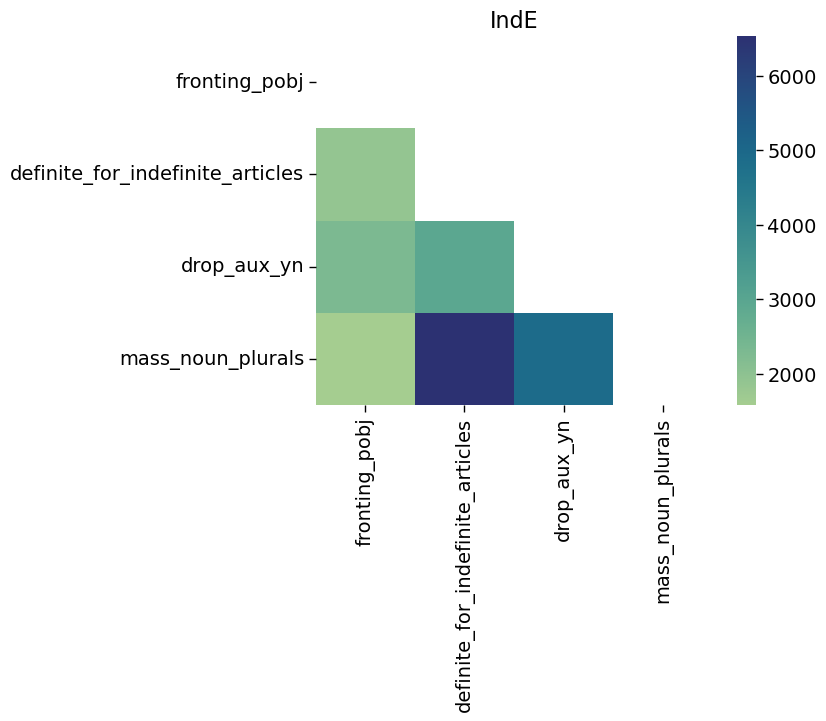

In [15]:
# dialects_to_consider = ['AppE', 'CollSgE', 'IndE', 'SEAmE', 'UAAVE']
sns.set_context("paper", rc={"font.size": 14, "axes.titlesize": 16, "axes.labelsize": 14,
                                "xtick.labelsize": 14, "ytick.labelsize": 14, "legend.fontsize": 14})

d = 'IndE'
target_rules = top_rules_by_dialect[top_rules_by_dialect["Dialect"] == d]["Grammar Rule"].values
dialect_slice = dialect_combined_df[ dialect_combined_df["Dialect"] == d]
relevant_slice = find_if_rule_executed(dialect_slice, target_rules)
co_occurrence = calc_cooccurence(relevant_slice, target_rules)

mask=np.triu(np.ones_like(co_occurrence, dtype=bool))
sns.heatmap(data=co_occurrence.astype('int32'), mask=mask, cmap="crest" )
plt.title(d)
plt.xticks()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'existential_it'),
  Text(1.5, 0, 'drop_aux_wh'),
  Text(2.5, 0, 'yall'),
  Text(3.5, 0, 'drop_aux_yn'),
  Text(4.5, 0, 'aint_be'),
  Text(5.5, 0, 'negative_concord'),
  Text(6.5, 0, 'drop_copula_be_NP'),
  Text(7.5, 0, 'remove_det_indefinite'),
  Text(8.5, 0, 'double_comparative'),
  Text(9.5, 0, 'plural_interrogative'),
  Text(10.5, 0, 'remove_det_definite')])

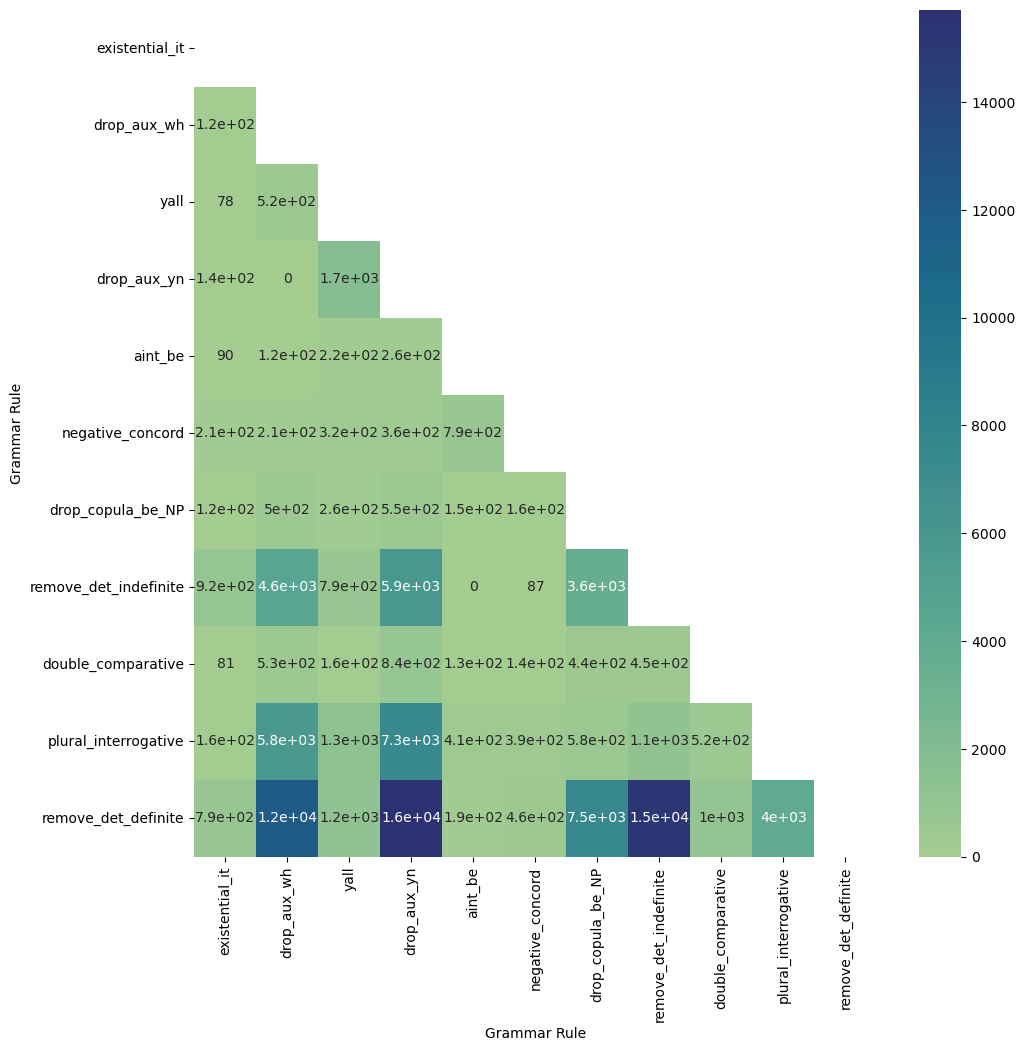

In [ ]:
rules_shared_dialects = sig_rules[(sig_rules["Dialect"].apply(lambda x: len(x) > 1)) & (sig_rules["Accuracy Difference"] < 0)]["Grammar Rule"]
d = 'UAAVE'
# target_rules = rules_by_dialect[rules_by_dialect["Dialect"] == d]["Grammar Rule"].values
# target_rules = target_rules[:15]
# print(target_rules)

# dialect_slice = dialect_combined_df[ dialect_combined_df["Dialect"] == d]

relevant_slice = find_if_rule_executed(dialect_combined_df, rules_shared_dialects)
co_occurrence = calc_cooccurence(relevant_slice, rules_shared_dialects)

mask=np.triu(np.ones_like(co_occurrence, dtype=bool))
fig, ax = plt.subplots(figsize=(11,11))   
sns.heatmap(data=co_occurrence.astype('int32'), mask=mask, cmap="crest", annot=True, ax=ax)
# plt.title(d)
plt.xticks()

In [37]:
len(target_rules)

25

# analyze interactions of existential it 

In [ ]:
import jsonlines 

df_list = []

for model in model_mapping: 
    for dataset in datasets: 
        print(model, dataset)
        if dataset == "mmlu": 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            pairs_log_path = base_path + f"{dataset}/pair_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"

            pair_df = load_files_matching(pairs_log_path)
            subset_df = load_files_matching(subset_log_path)
             # rules_df = load_files_matching(rules_log_path)
        else: 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            pairs_log_path = base_path + f"{dataset}/pair_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            
            subset_df = pd.read_json(subset_log_path, lines=True)
            pair_df = pd.read_json(pairs_log_path, lines=True)
            # rules_df = pd.read_json(rules_log_path, lines=True)

        combined_df = combine_orig_and_transform(subset_df, pair_df, model=model, transform_suffix="pair", rules_executed=True)
        combined_df["dataset"] = dataset
        combined_df["model"] = model 
        df_list.append(combined_df)

pair_combined_df = pd.concat(df_list)

gpt4o-mini boolq
exact_match
gpt4o-mini sciq
exact_match
gpt4o-mini mmlu
exact_match
gemma boolq
acc
gemma sciq
acc
gemma mmlu
acc
mistral-7b boolq
acc
mistral-7b sciq
acc
mistral-7b mmlu
acc


In [4]:
interactions_df = pair_combined_df[pair_combined_df["rules_executed_list"].apply(lambda x: len(set(x)) > 1)]

In [5]:
interactions_df

,id,transformed_text,rule_transform,rules_executed_list,acc_pair,orig_question,acc_orig,Accuracy Difference,dataset,model
0,2348,is it any state in the us where the drinking a...,existential_it+drop_copula_be_NP,"[drop_copula_be_NP, existential_it, existentia...",1,is there any state in the us where the drinkin...,1,0,boolq,gpt4o-mini
1,9065,is it an integer that has a reciprocal that an...,existential_it+drop_copula_be_NP,"[drop_copula_be_NP, existential_it, existentia...",0,is there an integer that has a reciprocal that...,1,-1,boolq,gpt4o-mini
2,2880,it is to be a return address on an envelope,existential_it+drop_aux_yn,"[existential_it, existential_it, drop_aux_yn]",0,does there have to be a return address on an e...,1,-1,boolq,gpt4o-mini
3,3221,the bible say it is an unforgivable sin,existential_it+drop_aux_yn,"[existential_it, existential_it, drop_aux_yn]",1,does the bible say there is an unforgivable sin,1,0,boolq,gpt4o-mini
4,2442,is it 2 versions of never isn't the same,existential_it+negative_concord,"[existential_it, existential_it, negative_conc...",0,are there 2 versions of never be the same,1,-1,boolq,gpt4o-mini
...,...,...,...,...,...,...,...,...,...,...
24996,7410,"While on a camping trip, a defendant became in...",existential_it+remove_det_definite,"[existential_it, existential_it, remove_det_de...",1,"While on a camping trip, a defendant became in...",1,0,mmlu,mistral-7b
24999,7413,A purchaser signed an agreement of sale to buy...,existential_it+remove_det_definite,"[remove_det_definite, remove_det_definite, rem...",1,A purchaser signed an agreement of sale to buy...,1,0,mmlu,mistral-7b
25021,7435,A uniformed United States Park Policeman pulle...,existential_it+remove_det_definite,"[existential_it, existential_it, remove_det_de...",0,A uniformed United States Park Policeman pulle...,1,-1,mmlu,mistral-7b
25037,7451,A woman owned an extensive art collection that...,existential_it+remove_det_definite,"[remove_det_definite, remove_det_definite, rem...",0,A woman owned an extensive art collection that...,0,0,mmlu,mistral-7b


In [ ]:
interactions_by_acc_diff = interactions_df.groupby(['rule_transform'])["Accuracy Difference"].mean().sort_values().index
acc_diffs = interactions_df.groupby(['rule_transform'])["Accuracy Difference"].mean().sort_values().values

data_list = [] 
for r, diff in zip(interactions_by_acc_diff, acc_diffs):
    rule_slice = interactions_df[interactions_df["rule_transform"] == r ] 
    # based on internet, use when over 25 differing 
    test_res = mcnemar_test(rule_slice["acc_orig"], rule_slice["acc_pair"], exact=False, correction=True)
    count = len(rule_slice["acc_orig"])/len(model_mapping)
    # test_res = mcnemar_test(rule_slice["acc_orig"], rule_slice["acc_rule"])
    data_list.append([r, diff, test_res[1], test_res[0], count])

interact_stats_df = pd.DataFrame(data_list, columns=["Grammar Rule", "Accuracy Difference", "pvalue", "Statistic", "Applied Count"]) 

In [7]:
interact_stats_df

,Grammar Rule,Accuracy Difference,pvalue,Statistic,Applied Count
0,existential_it+remove_det_indefinite,-0.034765,2.222884e-07,26.828897,815.0
1,existential_it+remove_det_definite,-0.028485,3.421570e-04,12.824242,550.0
2,existential_it+drop_copula_be_NP,-0.010582,8.025873e-01,0.062500,63.0
3,existential_it+plural_interrogative,0.005208,1.000000e+00,0.000000,64.0
4,existential_it+drop_aux_yn,0.010929,5.224313e-01,0.409091,122.0
5,existential_it+drop_aux_wh,0.017544,3.074342e-01,1.041667,114.0
6,existential_it+negative_concord,0.018182,5.049851e-01,0.444444,55.0


# focus analysis on existential it with determiners 

In [36]:
# two_rules = ["existential_it", "remove_det_indefinite"]
# pair = "existential_it+remove_det_indefinite" 
two_rules = ["existential_it", "remove_det_definite"]
pair = "existential_it+remove_det_definite" 


pair_slice = interactions_df[interactions_df["rule_transform"] == pair]

slices = [] 
for i, r in enumerate(two_rules): 
    # indiv_slice = rule_combined_df[rule_combined_df["rule_transform"].isin(two_rules)]
    indiv_slice = rule_combined_df[rule_combined_df["rule_transform"] == r]
    cols_to_keep = ["acc_rule", "transformed_text", "rule_transform"]
    id_cols = ["id", "dataset", "model"]
    print(i)
    merged_slice = pair_slice.merge(indiv_slice[id_cols + cols_to_keep], on=id_cols, suffixes=("", f"_rule{i}"))
    slices.append(merged_slice)

concat_sliced = pd.concat(slices)

0
1


In [ ]:

i = 0
slice_1 = slices[i]
rule_name = f"rule_transform_rule{i}"


r = slice_1[rule_name].unique()[0]

rule_slice = slice_1[slice_1[rule_name] == r ] 
rule_slice["Single Rule Acc Diff"] = rule_slice["acc_rule"] - rule_slice["acc_orig"]
diff = rule_slice["Single Rule Acc Diff"].mean()
test_res = mcnemar_test(rule_slice["acc_orig"], rule_slice["acc_rule"], exact=False, correction=True)
count = len(rule_slice["acc_orig"])/len(model_mapping)

data_list = [[r, diff, test_res[1], test_res[0], count]]

rule_1_stats_df = pd.DataFrame(data_list, columns=[rule_name, "Single Rule Acc Diff", "pvalue", "Statistic", "Applied Count"]) 
rule_1_stats_df

In [ ]:
i = 1
slice_1 = slices[i]
rule_name = f"rule_transform_rule{i}"


r = slice_1[rule_name].unique()[0]

rule_slice = slice_1[slice_1[rule_name] == r ] 
rule_slice["Single Rule Acc Diff"] = rule_slice["acc_rule"] - rule_slice["acc_orig"]
diff = rule_slice["Single Rule Acc Diff"].mean()
test_res = mcnemar_test(rule_slice["acc_orig"], rule_slice["acc_rule"], exact=False, correction=True)
count = len(rule_slice["acc_orig"])/len(model_mapping)

data_list = [[r, diff, test_res[1], test_res[0], count]]

rule_1_stats_df = pd.DataFrame(data_list, columns=[rule_name, "Single Rule Acc Diff", "pvalue", "Statistic", "Applied Count"]) 
rule_1_stats_df

In [26]:
slice_2 = slices[1]
slice_2[slice_2["acc_rule"] > slice_2["acc_pair"]]

,id,transformed_text,rule_transform,rules_executed_list,acc_pair,orig_question,acc_orig,Accuracy Difference,dataset,model,acc_rule,transformed_text_rule1,rule_transform_rule1
0,14,is it now you see me 3 coming out,existential_it+remove_det_indefinite,"[existential_it, existential_it, remove_det_in...",0,is there a now you see me 3 coming out,1,-1,boolq,gpt4o-mini,1,is there now you see me 3 coming out,remove_det_indefinite
24,512,is it dunkin donuts in all 50 states,existential_it+remove_det_indefinite,"[remove_det_indefinite, existential_it, existe...",0,is there a dunkin donuts in all 50 states,1,-1,boolq,gpt4o-mini,1,is there dunkin donuts in all 50 states,remove_det_indefinite
44,896,is it sequel to the last airbender,existential_it+remove_det_indefinite,"[remove_det_indefinite, existential_it, existe...",0,is there a sequel to the last airbender,1,-1,boolq,gpt4o-mini,1,is there sequel to the last airbender,remove_det_indefinite
51,987,is it tunnel between denmark and sweden,existential_it+remove_det_indefinite,"[remove_det_indefinite, existential_it, existe...",0,is there a tunnel between denmark and sweden,1,-1,boolq,gpt4o-mini,1,is there tunnel between denmark and sweden,remove_det_indefinite
68,1301,is it end credit scene in avengers infity war,existential_it+remove_det_indefinite,"[existential_it, existential_it, remove_det_in...",0,is there a end credit scene in avengers infity...,1,-1,boolq,gpt4o-mini,1,is there end credit scene in avengers infity war,remove_det_indefinite
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,3749,Statement 1 | The image of group of 6 elements...,existential_it+remove_det_indefinite,"[existential_it, existential_it, remove_det_in...",0,Statement 1 | The image of a group of 6 elemen...,1,-1,mmlu,mistral-7b,1,Statement 1 | The image of group of 6 elements...,remove_det_indefinite
2264,9630,It is two games involving flipping a fair coin...,existential_it+remove_det_indefinite,"[remove_det_indefinite, existential_it, existe...",0,There are two games involving flipping a fair ...,1,-1,mmlu,mistral-7b,1,There are two games involving flipping a fair ...,remove_det_indefinite
2280,10145,"At the beginning of class period, half of the ...",existential_it+remove_det_indefinite,"[existential_it, existential_it, remove_det_in...",0,"At the beginning of a class period, half of th...",0,0,mmlu,mistral-7b,1,"At the beginning of class period, half of the ...",remove_det_indefinite
2414,7112,Officer stopped car for having a burned out he...,existential_it+remove_det_indefinite,"[existential_it, existential_it, remove_det_in...",0,An officer stopped a car for having a burned o...,1,-1,mmlu,mistral-7b,1,Officer stopped car for having a burned out he...,remove_det_indefinite


In [30]:
rule_combined_df

,id,transformed_text,rule_transform,acc_rule,orig_question,acc_orig,Accuracy Difference,dataset,model
0,6,will there be the season 4 of da vinci's demons,definite_for_indefinite_articles,1,will there be a season 4 of da vinci's demons,1,0,boolq,gpt4o-mini
1,9,is batman and robin the sequel to batman forever,definite_for_indefinite_articles,1,is batman and robin a sequel to batman forever,1,0,boolq,gpt4o-mini
2,10,is the wolverine the same as the badger,definite_for_indefinite_articles,1,is a wolverine the same as a badger,1,0,boolq,gpt4o-mini
3,11,will there be the green lantern 2 movie,definite_for_indefinite_articles,1,will there be a green lantern 2 movie,1,0,boolq,gpt4o-mini
4,14,is there the now you see me 3 coming out,definite_for_indefinite_articles,1,is there a now you see me 3 coming out,1,0,boolq,gpt4o-mini
...,...,...,...,...,...,...,...,...,...
118340,2468,One is a true statement concerning genetic var...,one_relativizer,1,Which is a true statement concerning genetic v...,1,0,mmlu,mistral-7b
118341,2469,The primary site of glucose reabsorption one i...,one_relativizer,1,The primary site of glucose reabsorption is the,1,0,mmlu,mistral-7b
118342,2470,Statement about natural selection one is most ...,one_relativizer,1,Which statement about natural selection is mos...,1,0,mmlu,mistral-7b
118343,2471,This process one couples the production of ATP...,one_relativizer,1,This process couples the production of ATP wit...,1,0,mmlu,mistral-7b


# check for existential it in its 3 dialects 

In [144]:
# rule = "existential_it"
rule = "drop_copula_be_NP"
# rule = "yall"
# rule = "fronting_pobj"
# rule = "drop_aux_wh"

rule_slice = rule_combined_df[rule_combined_df["rule_transform"] == rule]

In [ ]:
def find_if_rule_executed(dialect_slice, rules): 
    relevant_rules_slice = dialect_slice[dialect_slice["rules_executed_list"].apply(lambda l: any(rule in l for rule in rules))].copy()
    # First, create binary columns for each target rule
    for rule in rules:
        relevant_rules_slice[rule] = relevant_rules_slice['rules_executed_list'].apply(lambda x: 1 if rule in x else 0)

    return relevant_rules_slice

target_rules = [rule]
relevant_dialect_slice = find_if_rule_executed(dialect_combined_df, target_rules)

relevant_dialect_slice

,id,transformed_text,rule_transform,rules_executed_list,acc_dialect,orig_question,acc_orig,Accuracy Difference,dataset,model,Dialect,drop_copula_be_NP
2,2,windows movie maker part of windows essentials,Urban African American Vernacular English,[drop_copula_be_NP],1,is windows movie maker part of windows essentials,1,0,boolq,gpt4o-mini,UAAVE,1
3,3,confectionary sugar the same as powdered sugar,Urban African American Vernacular English,[drop_copula_be_NP],1,is confectionary sugar the same as powdered sugar,1,0,boolq,gpt4o-mini,UAAVE,1
4,4,more elder scrolls online the same as skyrim,Urban African American Vernacular English,"[drop_copula_be_NP, double_comparative]",0,is elder scrolls online the same as skyrim,1,-1,boolq,gpt4o-mini,UAAVE,1
9,9,batman and robin one sequel to batman forever,Urban African American Vernacular English,"[drop_copula_be_NP, indef_one]",1,is batman and robin a sequel to batman forever,1,0,boolq,gpt4o-mini,UAAVE,1
10,10,a wolverine the same as a badger,Urban African American Vernacular English,[drop_copula_be_NP],1,is a wolverine the same as a badger,1,0,boolq,gpt4o-mini,UAAVE,1
...,...,...,...,...,...,...,...,...,...,...,...,...
62010,2924,David Baltimore a molecular biologist. What di...,ColloquialSingaporeDialect,"[null_referential_pronouns, drop_aux_yn, drop_...",1,David Baltimore is a molecular biologist. What...,1,0,mmlu,mistral-7b,CollSgE,1
62047,2961,Which following the most important controlling...,ColloquialSingaporeDialect,"[zero_plural, null_prepositions, null_preposit...",1,Which of the following is the most important f...,1,0,mmlu,mistral-7b,CollSgE,1
62049,2963,And important The most widespread retrovirus o...,ColloquialSingaporeDialect,"[drop_copula_be_NP, null_prepositions, acomp_f...",0,The most widespread and important retrovirus i...,0,0,mmlu,mistral-7b,CollSgE,1
62063,2977,Interferon very special defence mechanismses w...,ColloquialSingaporeDialect,"[zero_plural, regularized_plurals, progressive...",0,Interferons are very special defence mechanism...,0,0,mmlu,mistral-7b,CollSgE,1


In [150]:
id_cols = ["id", "dataset", "model"]
content_cols = ["transformed_text", "acc_rule", "Accuracy Difference"]
merged_slice = relevant_dialect_slice.merge(rule_slice[content_cols + id_cols], on=["id", "dataset", "model"], suffixes=("", "_rule"))

In [154]:
relevant_dialect_slice.groupby(["Dialect"])["Accuracy Difference"].count()

Dialect
CollSgE    12438
IndE        2415
UAAVE      14280
Name: Accuracy Difference, dtype: int64

In [ ]:
# relevant_dialect_oblig_slice = find_if_rule_executed(dialect_oblig_combined_df, target_rules)
relevant_dialect_oblig_slice.groupby(["Dialect"])["Accuracy Difference"].count()

Dialect
CollSgE    12525
UAAVE      17262
Name: Accuracy Difference, dtype: int64

In [152]:
len(rule_slice)

17733

In [143]:
merged_slice.groupby(["Dialect"])["Accuracy Difference"].count()

Dialect
AppE       2397
ChcE       1986
CollSgE    2451
SEAmE       999
UAAVE      2181
Name: Accuracy Difference, dtype: int64

In [65]:
merged_slice.groupby(["Dialect"])["Accuracy Difference_rule"].mean()

Dialect
AppE      -0.012526
ChcE      -0.010187
CollSgE   -0.021073
IndE      -0.012802
SEAmE     -0.011887
UAAVE     -0.013225
Name: Accuracy Difference_rule, dtype: float64

In [138]:
relevant_dialect_slice.groupby(["Dialect"])["Accuracy Difference"].count()//3

Dialect
AppE       799
ChcE       662
CollSgE    817
SEAmE      333
UAAVE      727
Name: Accuracy Difference, dtype: int64

In [66]:
merged_slice.groupby(["Dialect"])["Accuracy Difference"].mean()

Dialect
AppE      -0.015849
ChcE      -0.012632
CollSgE   -0.029693
IndE      -0.023634
SEAmE     -0.017956
UAAVE     -0.012023
Name: Accuracy Difference, dtype: float64

# obligatory rules vs whole dialect 

In [6]:
df_list = []

for model in model_mapping: 
    for dataset in datasets: 
        print("model", model)
        print("dataset", dataset)
        if dataset == "mmlu": 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            dialects_oblig_log_path = base_path + f"{dataset}/dialect_oblig_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"

            dialect_oblig_df = load_files_matching(dialects_oblig_log_path)
            subset_df = load_files_matching(subset_log_path)
             # rules_df = load_files_matching(rules_log_path)
        else: 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            dialects_oblig_log_path = base_path + f"{dataset}/dialect_oblig_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # dialects_log_path = base_path + f"{dataset}/dialect_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"

            subset_df = pd.read_json(subset_log_path, lines=True)
            dialect_oblig_df = pd.read_json(dialects_oblig_log_path, lines=True)
            # rules_df = pd.read_json(rules_log_path, lines=True)

        combined_df = combine_orig_and_transform(subset_df, dialect_oblig_df, model=model, transform_suffix="dialect_oblig", rules_executed=True)
        combined_df["dataset"] = dataset
        combined_df["model"] = model 
        df_list.append(combined_df)

dialect_oblig_combined_df = pd.concat(df_list)

model gpt4o-mini
dataset boolq
exact_match
model gpt4o-mini
dataset sciq
exact_match
model gpt4o-mini
dataset mmlu
exact_match
model gemma
dataset boolq
acc
model gemma
dataset sciq
acc
model gemma
dataset mmlu
acc
model mistral-7b
dataset boolq
acc
model mistral-7b
dataset sciq
acc
model mistral-7b
dataset mmlu
acc


In [7]:
dialect_mapping = {
    "AfricanAmericanVernacular": "UAAVE",
    "SoutheastAmericanEnclaveDialect" : "SEAmE", 
    "AppalachianDialect": "AppE", 
    "IndianDialect": "IndE", 
    "ColloquialSingaporeDialect": "CollSgE", 
    "ChicanoDialect": "ChcE",
    
    # oops somehow data file has two naming conventions, standardize
    "Urban African American Vernacular English": "UAAVE",
    "Southeast American enclave dialects" : "SEAmE", 
    "Appalachian English": "AppE", 
    "Indian English": "IndE", 
    "Colloquial Singapore English (Singlish)": "CollSgE",
    "Chicano English": "ChcE",
}


dialect_combined_df["Dialect"] = dialect_combined_df["rule_transform"].apply(lambda x: dialect_mapping[x])
dialect_oblig_combined_df["Dialect"] = dialect_oblig_combined_df["rule_transform"].apply(lambda x: dialect_mapping[x])

In [16]:
cols_to_keep = ["transformed_text", "rules_executed_list", "acc_dialect"]
id_cols = ["id", "dataset", "model", "Dialect"]

oblig_and_full_df = dialect_oblig_combined_df.merge(dialect_combined_df[cols_to_keep + id_cols], on=id_cols, suffixes=("_dialect_oblig", "_dialect"))

In [20]:
oblig_and_full_df["Accuracy Difference from SAE"] = oblig_and_full_df["acc_dialect"] - oblig_and_full_df["acc_orig"]

/tmp/ipykernel_3274239/3220364361.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Dialect", y="Accuracy Difference from SAE", data=oblig_and_full_df, order=dialect_order, ci=None,  color='lightblue', label='all dialect rules')
/tmp/ipykernel_3274239/3220364361.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Dialect", y="Accuracy Difference", data=oblig_and_full_df, order=dialect_order, ci=None,  color='darkblue', label='obligatory dialect rules')


<Axes: xlabel='Dialect', ylabel='Accuracy Difference from SAE'>

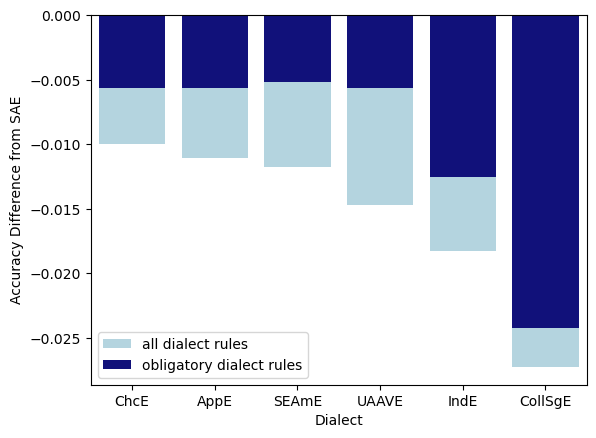

In [21]:
dialect_order = ["ChcE", "AppE", "SEAmE", "UAAVE", "IndE", "CollSgE"]

sns.barplot(x="Dialect", y="Accuracy Difference from SAE", data=oblig_and_full_df, order=dialect_order, ci=None,  color='lightblue', label='all dialect rules')
sns.barplot(x="Dialect", y="Accuracy Difference", data=oblig_and_full_df, order=dialect_order, ci=None,  color='darkblue', label='obligatory dialect rules')

## unnest columns

In [35]:
rule_group_col = "Rules Used"
dialect_combined_df[rule_group_col] = "All Dialect Rules"
dialect_oblig_combined_df[rule_group_col] = "Obligatory Dialect Rules"
dialect_combined_df["acc"] = dialect_combined_df["acc_dialect"]
dialect_oblig_combined_df["acc"] = dialect_oblig_combined_df["acc_dialect_oblig"]

rows_to_keep = ["id", "rules_executed_list","Dialect", "Rules Used", "dataset", "model", "acc_orig", "Accuracy Difference", "acc"]

oblig_and_full_longform = pd.concat([dialect_combined_df[rows_to_keep], dialect_oblig_combined_df[rows_to_keep]])
oblig_and_full_longform["Accuracy Difference (%)"] = oblig_and_full_longform["Accuracy Difference"] *100
oblig_and_full_longform

,id,rules_executed_list,Dialect,Rules Used,dataset,model,acc_orig,Accuracy Difference,acc,Accuracy Difference (%)
0,0,"[invariant_tag_non_concord, invariant_tag_non_...",UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1,0
1,1,"[those_them, drop_aux_yn, zero_plural, null_re...",UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1,0
2,2,[drop_copula_be_NP],UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1,0
3,3,[drop_copula_be_NP],UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1,0
4,4,"[drop_copula_be_NP, double_comparative]",UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,-1,0,-100
...,...,...,...,...,...,...,...,...,...,...
45265,898,"[drop_aux_wh, null_prepositions, null_preposit...",CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,1,0,1,0
45266,899,"[remove_det_definite, regularized_plurals, dro...",CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,1,0,1,0
45267,900,"[zero_plural, zero_plural, zero_plural, one_re...",CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,1,0,1,0
45268,901,"[null_prepositions, null_prepositions, drop_au...",CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,1,-1,0,-100


In [27]:
oblig_and_full_longform[(oblig_and_full_longform["Dialect"] == "ChcE") & (oblig_and_full_longform["Rules Used"] == "Obligatory Dialect Rules")]

,id,rules_executed_list,Dialect,Rules Used,dataset,model,acc_orig,Accuracy Difference,acc
11915,353,"[negative_concord, negative_concord]",ChcE,Obligatory Dialect Rules,boolq,gpt4o-mini,1,0,1
11916,531,"[negative_concord, negative_concord]",ChcE,Obligatory Dialect Rules,boolq,gpt4o-mini,1,0,1
11917,792,[negative_concord],ChcE,Obligatory Dialect Rules,boolq,gpt4o-mini,1,0,1
11918,1367,"[negative_concord, negative_concord]",ChcE,Obligatory Dialect Rules,boolq,gpt4o-mini,1,0,1
11919,1396,"[negative_concord, negative_concord]",ChcE,Obligatory Dialect Rules,boolq,gpt4o-mini,1,0,1
...,...,...,...,...,...,...,...,...,...
44964,769,"[negative_concord, negative_concord, negative_...",ChcE,Obligatory Dialect Rules,mmlu,mistral-7b,0,0,0
44965,806,"[negative_concord, negative_concord, negative_...",ChcE,Obligatory Dialect Rules,mmlu,mistral-7b,0,0,0
44966,815,[negative_concord],ChcE,Obligatory Dialect Rules,mmlu,mistral-7b,0,0,0
44967,853,"[negative_concord, negative_concord]",ChcE,Obligatory Dialect Rules,mmlu,mistral-7b,1,0,1


In [28]:
oblig_and_full_longform.groupby(["Rules Used", "Dialect"])["id"].count()

Rules Used                Dialect
All Dialect Rules         AppE       76029
                          ChcE       44259
                          CollSgE    97731
                          IndE       97518
                          SEAmE      92472
                          UAAVE      95112
Obligatory Dialect Rules  AppE       39129
                          ChcE        3012
                          CollSgE    95229
                          IndE       96279
                          SEAmE      64419
                          UAAVE      66426
Name: id, dtype: int64

In [33]:
filtered_oblig = oblig_and_full_longform[oblig_and_full_longform["Accuracy Difference"] < 0]

filtered_oblig.groupby(["Rules Used", "Dialect"])["Accuracy Difference"].count()

Rules Used                Dialect
All Dialect Rules         AppE       2537
                          ChcE       1220
                          CollSgE    6078
                          IndE       4919
                          SEAmE      3587
                          UAAVE      4107
Obligatory Dialect Rules  AppE        986
                          ChcE         84
                          CollSgE    5440
                          IndE       3929
                          SEAmE      1715
                          UAAVE      1924
Name: Accuracy Difference, dtype: int64

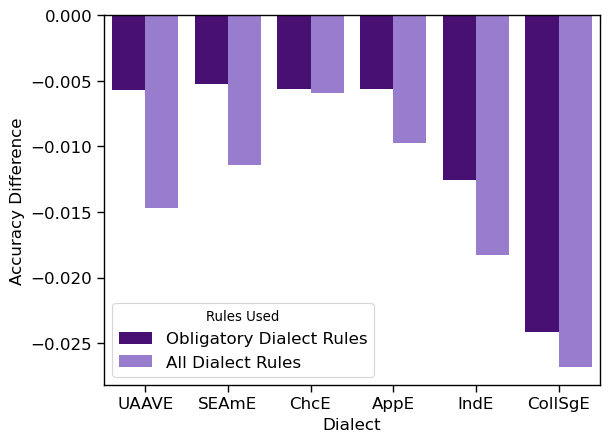

In [34]:
ax = sns.barplot(
        oblig_and_full_longform, 
        y="Accuracy Difference", 
        x="Dialect", 
        hue="Rules Used",
        hue_order=["Obligatory Dialect Rules", "All Dialect Rules"],
        palette = {
                "Obligatory Dialect Rules": 'indigo',
                "All Dialect Rules": 'mediumpurple',
            },
        errorbar=None,
    )

## SAE correct

In [36]:
sae_correct_oblig_and_full = oblig_and_full_longform[oblig_and_full_longform["acc_orig"] == 1]
bar_counts = sae_correct_oblig_and_full.groupby(["Rules Used", "Dialect"])["id"].count()
bar_counts

Rules Used                Dialect
All Dialect Rules         AppE       58683
                          ChcE       32135
                          CollSgE    75779
                          IndE       75618
                          SEAmE      71642
                          UAAVE      73838
Obligatory Dialect Rules  AppE       29851
                          ChcE        1843
                          CollSgE    74181
                          IndE       74690
                          SEAmE      48688
                          UAAVE      50129
Name: id, dtype: int64

Text(0.5, 1.0, '')

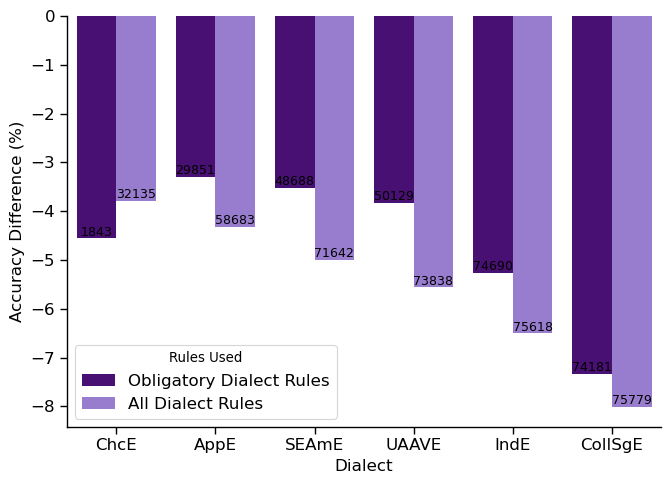

In [39]:
# Set the context with a specific font size
sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12,
                                "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12})
                                

dialect_order = ["ChcE", "AppE", "SEAmE", "UAAVE", "IndE", "CollSgE"]
rule_order = ["Obligatory Dialect Rules", "All Dialect Rules"]

rp = sns.catplot(
        sae_correct_oblig_and_full, 
        kind="bar",
        # y="Accuracy Difference", 
        y="Accuracy Difference (%)",
        x="Dialect", 
        hue="Rules Used",
        order=dialect_order,
        hue_order=rule_order,
        # palette={"Obligatory Dialect Rules": "darkblue", "All Dialect Rules": "skyblue"},
        palette = {
                # 'Rule Applied': 'navy',
                "Obligatory Dialect Rules": 'indigo',
                "All Dialect Rules": 'mediumpurple',
            },
        errorbar=None,
        aspect=5.5/4,
        legend_out=False,
    )
ax = rp.ax
# Annotate each container (one per hue level)
for container, rule in zip(ax.containers, rule_order):
    for bar, dialect in zip(container, dialect_order):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        count = bar_counts.get((rule, dialect), 0)
        ax.text(x, height - 0.003, str(count), ha='center', va='bottom', fontsize=9, color='black')

ax.set_title("")

## SAE correct, but unperturbed returned to analysis 

In [ ]:
dialect_empty_combined_df

In [ ]:
dialects = dialect_oblig_combined_df["Dialect"].unique()

dialect_slices = [] 

for d in dialects: 
    dialect_slice = dialect_oblig_combined_df[dialect_oblig_combined_df["Dialect"] == d] 
    unperturbed_rows = filter_non_matching_rows(orig_combined_df, dialect_slice)
    unperturbed_rows["acc_dialect"] = unperturbed_rows["acc"]
    unperturbed_rows["acc_orig"] = unperturbed_rows["acc"]
    unperturbed_rows["transformed_text"] = unperturbed_rows["orig_question"]
    unperturbed_rows["Dialect"] = d
    # unperturbed_rows["rules_executed_list"] = []*len(unperturbed_rows)
    unperturbed_rows["Accuracy Difference"] = 0
    
    filled_in_dialect_slice = pd.concat([dialect_slice, unperturbed_rows])
    dialect_slices.append(filled_in_dialect_slice)

dialect_oblig_empty_combined_df = pd.concat(dialect_slices)

In [83]:
rule_group_col = "Rules Used"
dialect_empty_combined_df[rule_group_col] = "All Dialect Rules"
dialect_oblig_empty_combined_df[rule_group_col] = "Obligatory Dialect Rules"
dialect_empty_combined_df["acc"] = dialect_empty_combined_df["acc_dialect"]
dialect_oblig_empty_combined_df["acc"] = dialect_oblig_empty_combined_df["acc_dialect"]

rows_to_keep = ["id", "rules_executed_list","Dialect", "Rules Used", "dataset", "model", "acc_orig", "Accuracy Difference", "acc"]

oblig_and_full_empty  = pd.concat([dialect_empty_combined_df[rows_to_keep], dialect_oblig_empty_combined_df[rows_to_keep]])
oblig_and_full_empty

,id,rules_executed_list,Dialect,Rules Used,dataset,model,acc_orig,Accuracy Difference,acc
0,0,"[invariant_tag_non_concord, invariant_tag_non_...",UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1.0
1,1,"[those_them, drop_aux_yn, zero_plural, null_re...",UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1.0
2,2,[drop_copula_be_NP],UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1.0
3,3,[drop_copula_be_NP],UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,0,1.0
4,4,"[drop_copula_be_NP, double_comparative]",UAAVE,All Dialect Rules,boolq,gpt4o-mini,1,-1,0.0
...,...,...,...,...,...,...,...,...,...
97892,7886,NaN,CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,0,0,0.0
97898,7892,NaN,CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,0,0,0.0
97909,7903,NaN,CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,1,0,1.0
97943,5435,NaN,CollSgE,Obligatory Dialect Rules,mmlu,mistral-7b,0,0,0.0


## SAE correct, unperturbed kept 

In [84]:
sae_correct_oblig_and_full_empty = oblig_and_full_empty[oblig_and_full_empty["acc_orig"] == 1]
bar_counts = sae_correct_oblig_and_full_empty.groupby(["Rules Used", "Dialect"])["id"].count()
bar_counts

Rules Used                Dialect
All Dialect Rules         AppE       75940
                          ChcE       75940
                          CollSgE    75940
                          IndE       75940
                          SEAmE      75940
                          UAAVE      75940
Obligatory Dialect Rules  AppE       75940
                          ChcE       75940
                          CollSgE    75940
                          IndE       75940
                          SEAmE      75940
                          UAAVE      75940
Name: id, dtype: int64

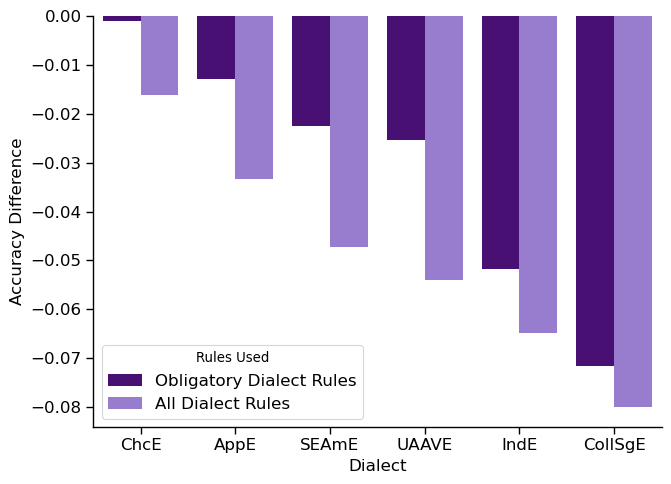

In [ ]:
# Set the context with a specific font size
sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12,
                                "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12})
                                

dialect_order = ["ChcE", "AppE", "SEAmE", "UAAVE", "IndE", "CollSgE"]
rule_order = ["Obligatory Dialect Rules", "All Dialect Rules"]

rp = sns.catplot(
        sae_correct_oblig_and_full_empty, 
        kind="bar",
        y="Accuracy Difference", 
        x="Dialect", 
        hue="Rules Used",
        order=dialect_order,
        hue_order=rule_order,
        # palette={"Obligatory Dialect Rules": "darkblue", "All Dialect Rules": "skyblue"},
        palette = {
                # 'Rule Applied': 'navy',
                "Obligatory Dialect Rules": 'indigo',
                "All Dialect Rules": 'mediumpurple',
            },
        errorbar=None,
        aspect=5.5/4,
        legend_out=False,
    )


# most consequential obligatory rule by dialect

In [40]:
most_consequential_rule = {
    "ChcE": "negative_concord", 
    "AppE": "existential_it", 
    "SEAmE": "proximal_distal_demonstratives", 
    "UAAVE": "existential_it", 
    "IndE": "fronting_pobj", 
    "CollSgE": "null_prepositions", 
}

In [41]:
rule_combined_df

,id,transformed_text,rule_transform,acc_rule,orig_question,acc_orig,Accuracy Difference,dataset,model
0,6,will there be the season 4 of da vinci's demons,definite_for_indefinite_articles,1,will there be a season 4 of da vinci's demons,1,0,boolq,gpt4o-mini
1,9,is batman and robin the sequel to batman forever,definite_for_indefinite_articles,1,is batman and robin a sequel to batman forever,1,0,boolq,gpt4o-mini
2,10,is the wolverine the same as the badger,definite_for_indefinite_articles,1,is a wolverine the same as a badger,1,0,boolq,gpt4o-mini
3,11,will there be the green lantern 2 movie,definite_for_indefinite_articles,1,will there be a green lantern 2 movie,1,0,boolq,gpt4o-mini
4,14,is there the now you see me 3 coming out,definite_for_indefinite_articles,1,is there a now you see me 3 coming out,1,0,boolq,gpt4o-mini
...,...,...,...,...,...,...,...,...,...
118340,2468,One is a true statement concerning genetic var...,one_relativizer,1,Which is a true statement concerning genetic v...,1,0,mmlu,mistral-7b
118341,2469,The primary site of glucose reabsorption one i...,one_relativizer,1,The primary site of glucose reabsorption is the,1,0,mmlu,mistral-7b
118342,2470,Statement about natural selection one is most ...,one_relativizer,1,Which statement about natural selection is mos...,1,0,mmlu,mistral-7b
118343,2471,This process one couples the production of ATP...,one_relativizer,1,This process couples the production of ATP wit...,1,0,mmlu,mistral-7b


In [42]:
cols_to_keep = ["transformed_text_dialect", "rules_executed_list_dialect", "transformed_text_dialect_oblig", "rules_executed_list_dialect_oblig", "acc_dialect","acc_dialect_oblig", "Dialect"]
id_cols = ["id", "dataset", "model"]

restricted_slices = [] 

for d, rule in most_consequential_rule.items(): 
    rule_slice = rule_combined_df[rule_combined_df["rule_transform"] == rule]
    oblig_slice = oblig_and_full_df[oblig_and_full_df["Dialect"] == d]
    restricted_slice = rule_slice.merge(oblig_slice[cols_to_keep + id_cols], on=id_cols)
    restricted_slices.append(restricted_slice)


restricted_df = pd.concat(restricted_slices)
    

NameError: name 'oblig_and_full_df' is not defined

In [21]:
restricted_df["Accuracy Difference from SAE"] = restricted_df["acc_dialect"] - restricted_df["acc_orig"]
restricted_df["Accuracy Difference (oblig)"] = restricted_df["acc_dialect_oblig"] - restricted_df["acc_orig"]
restricted_df["Accuracy Difference (rule)"] = restricted_df["acc_rule"] - restricted_df["acc_orig"]

In [22]:
restricted_df

,id,transformed_text,rule_transform,acc_rule,orig_question,acc_orig,Accuracy Difference,dataset,model,transformed_text_dialect,rules_executed_list_dialect,transformed_text_dialect_oblig,rules_executed_list_dialect_oblig,acc_dialect,acc_dialect_oblig,Dialect,Accuracy Difference from SAE,Accuracy Difference (oblig),Accuracy Difference (rule)
0,353,is ain't no word in the webster dictionary,negative_concord,1,is ain't a word in the webster dictionary,1,0,boolq,gpt4o-mini,is ain't no word in the webster dictionary,"[negative_concord, negative_concord, aint_be]",is ain't no word in the webster dictionary,"[negative_concord, negative_concord]",1,1,ChcE,0,0,0
1,531,was can't stop no feeling written for trolls,negative_concord,1,was can't stop the feeling written for trolls,1,0,boolq,gpt4o-mini,ai might cann't stop no feeling wrote for trolls,"[double_modals, past_for_past_participle, aint...",was can't stop no feeling written for trolls,"[negative_concord, negative_concord]",1,1,ChcE,0,0,0
2,792,is it illegal to not do jury no duty,negative_concord,1,is it illegal to not do jury duty,1,0,boolq,gpt4o-mini,is it like illegal to not do jury no duty,"[acomp_focusing_like, negative_concord]",is it illegal to not do jury no duty,[negative_concord],1,1,ChcE,0,0,0
3,1367,is isn't able to spell a form of dyslexia,negative_concord,1,is not being able to spell a form of dyslexia,1,0,boolq,gpt4o-mini,is ain't like able to spell a form of dyslexia,"[aint_be, aint_be, acomp_focusing_like]",is isn't able to spell a form of dyslexia,"[negative_concord, negative_concord]",0,1,ChcE,-1,0,0
4,1396,citizen kane did not do well at box no office ...,negative_concord,1,citizen kane did not do well at the box office...,1,0,boolq,gpt4o-mini,citizen kane did not do well at box no office ...,"[negative_concord, negative_concord, null_refe...",citizen kane did not do well at box no office ...,"[negative_concord, negative_concord]",1,1,ChcE,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82063,2467,The base composition DNA varies one species an...,null_prepositions,1,The base composition of DNA varies from one sp...,1,0,mmlu,mistral-7b,Base composition DNA is varying one species an...,"[progressives, null_prepositions, null_preposi...",Base composition DNA varies one species anothe...,"[remove_det_definite, remove_det_definite, zer...",0,1,CollSgE,-1,0,0
82064,2469,The primary site glucose reabsorption is the,null_prepositions,1,The primary site of glucose reabsorption is the,1,0,mmlu,mistral-7b,That primary site glucose reabsorption the,"[null_prepositions, drop_copula_be_NP, demonst...",The primary site of glucose reabsorption one the,"[drop_copula_be_NP, one_relativizer, one_relat...",1,1,CollSgE,0,0,0
82065,2470,Which statement natural selection is most corr...,null_prepositions,1,Which statement about natural selection is mos...,1,0,mmlu,mistral-7b,Which statement natural selection like most co...,"[drop_aux_wh, null_prepositions, acomp_focusin...",Which statement natural selection most correct?,"[drop_aux_wh, null_prepositions]",1,1,CollSgE,0,0,0
82066,2471,This process couples the production ATP the mo...,null_prepositions,1,This process couples the production of ATP wit...,1,0,mmlu,mistral-7b,This process one couple production ATP movemen...,"[remove_det_indefinite, remove_det_definite, r...",This process one couples production ATP moveme...,"[null_prepositions, null_prepositions, null_pr...",1,1,CollSgE,0,0,0


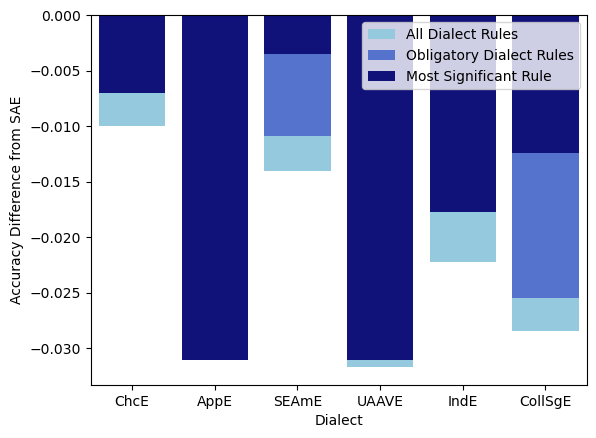

In [28]:
dialect_order = ["ChcE", "AppE", "SEAmE", "UAAVE", "IndE", "CollSgE"]

sns.barplot(x="Dialect", y="Accuracy Difference from SAE", data=restricted_df, order=dialect_order, errorbar=None,  color='skyblue', label='All Dialect Rules')
sns.barplot(x="Dialect", y="Accuracy Difference (oblig)", data=restricted_df, order=dialect_order, errorbar=None, color='royalblue', label='Obligatory Dialect Rules')
sns.barplot(x="Dialect", y="Accuracy Difference (rule)", data=restricted_df, order=dialect_order,  errorbar=None, color='darkblue', label='Most Significant Rule')
plt.legend( loc='upper right')

# Specific Rule Analysis 

single rule, oblig rules, dialects by 

In [59]:
# rule_in_focus = "existential_it"
# dialects = ["AppE", "UAAVE", "CollSgE"]

# rule_in_focus = "drop_copula_be_NP"
# dialects = ["UAAVE", "CollSgE"]

rule_in_focus = "yall"
dialects = ["SEAmE", "AppE", "UAAVE"]

# rule_in_focus = "aint_be"
# dialects = ["SEAmE", "AppE", "UAAVE"]

# rule_in_focus = "invariant_tag_non_concord"
# dialects = ["IndE", "CollSgE"]

# rule_in_focus = "drop_aux_yn"
# dialects = ["IndE", "CollSgE"]

# rule_in_focus = "drop_aux_wh"
# dialects = ["IndE", "CollSgE"]

# rule_in_focus = "progressives"
# dialects = ["IndE", "SEAmE"]


In [60]:
cols_to_keep = ["transformed_text_dialect", "rules_executed_list_dialect", "transformed_text_dialect_oblig", "rules_executed_list_dialect_oblig", "acc_dialect","acc_dialect_oblig", "Dialect"]
id_cols = ["id", "dataset", "model"]

restricted_slices = [] 

for d in dialects: 
    rule_slice = rule_combined_df[rule_combined_df["rule_transform"] == rule_in_focus]
    oblig_slice = oblig_and_full_df[oblig_and_full_df["Dialect"] == d]
    restricted_slice = rule_slice.merge(oblig_slice[cols_to_keep + id_cols], on=id_cols)
    restricted_slices.append(restricted_slice)


restricted_df = pd.concat(restricted_slices)

restricted_df["Accuracy Difference from SAE"] = restricted_df["acc_dialect"] - restricted_df["acc_orig"]
restricted_df["Accuracy Difference (oblig)"] = restricted_df["acc_dialect_oblig"] - restricted_df["acc_orig"]
restricted_df["Accuracy Difference (rule)"] = restricted_df["acc_rule"] - restricted_df["acc_orig"]

In [61]:
dialect_restricted_list = []

datasets = ["boolq", "mmlu", "sciq"]

for d in dialects: 
    # we need to calc a sep intersection per dialect bc the rules didn't apply when simultaneous order of ops 
    for data in datasets: 
        dialect_slice = restricted_df[restricted_df["Dialect"] == d]
        dialect_slice = dialect_slice[dialect_slice["dataset"] == data]
        if len(dialect_slice) == 0: 
            print( f"nothing for {d} {data}")
            continue 
        oblig_rule_ids = set(
        dialect_slice[dialect_slice["rules_executed_list_dialect_oblig"].apply(lambda x: rule_in_focus in set(x))]["id"]
        )
        all_dialect_ids = set(
            dialect_slice[dialect_slice["rules_executed_list_dialect"].apply(lambda x: rule_in_focus in set(x))]["id"]
        )

        combined_ids = list(oblig_rule_ids.intersection(all_dialect_ids))
        print(len(combined_ids))
        dialect_restricted_slice = dialect_slice[dialect_slice["id"].isin(combined_ids)]
        dialect_restricted_list.append(dialect_restricted_slice)

dialect_restricted_df = pd.concat(dialect_restricted_list)

845
263
210
852
253
199
668
246
195


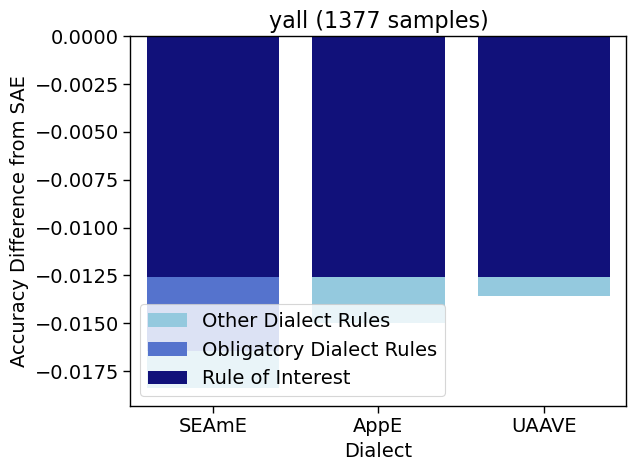

In [62]:
sns.set_context("paper", rc={"font.size": 14, "axes.titlesize": 16, "axes.labelsize": 14,
                                "xtick.labelsize": 14, "ytick.labelsize": 14, "legend.fontsize": 14})

sns.barplot(x="Dialect", y="Accuracy Difference from SAE", data=restricted_df, order=dialects, errorbar=None,  color='skyblue', label='Other Dialect Rules')
sns.barplot(x="Dialect", y="Accuracy Difference (oblig)", data=restricted_df, order=dialects, errorbar=None, color='royalblue', label='Obligatory Dialect Rules')
sns.barplot(x="Dialect", y="Accuracy Difference (rule)", data=restricted_df, order=dialects,  errorbar=None, color='darkblue', label='Rule of Interest')
# plt.title(f"{rule_in_focus} ({len(rule_slice)//3} samples)" )
plt.title(f"{rule_in_focus} ({len(rule_slice)//3} samples)" )
plt.legend( loc='lower left')
# plt.legend('', frameon=False)

## Unstacked Version 

In [63]:
# Melt the DataFrame to longform for accuracy columns
longform_restricted_df = pd.melt(
    dialect_restricted_df,
    id_vars=id_cols + ["Dialect", "acc_orig"],  # Keep identifying columns
    value_vars=["acc_dialect", "acc_dialect_oblig", "acc_rule"],
    var_name="Rules Used",
    value_name="acc"
)

rename_map = {
    "acc_dialect" : "All Dialect Rules", 
    "acc_dialect_oblig" : "Obligatory Dialect Rules", 
    "acc_rule" : "Rule of Interest", 
    # "acc_rule" : rule_in_focus, 
}   

acc_name = "Accuracy Difference from SAE (%)"
longform_restricted_df["Rules Used"] = longform_restricted_df["Rules Used"].apply(lambda x: rename_map[x])
longform_restricted_df[acc_name] = (longform_restricted_df["acc"] - longform_restricted_df["acc_orig"])*100

/tmp/ipykernel_3274239/2749906092.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longform_restricted_df_sae_corr["Dialect (samples)"] = longform_restricted_df_sae_corr["Dialect"].map(count_labels)


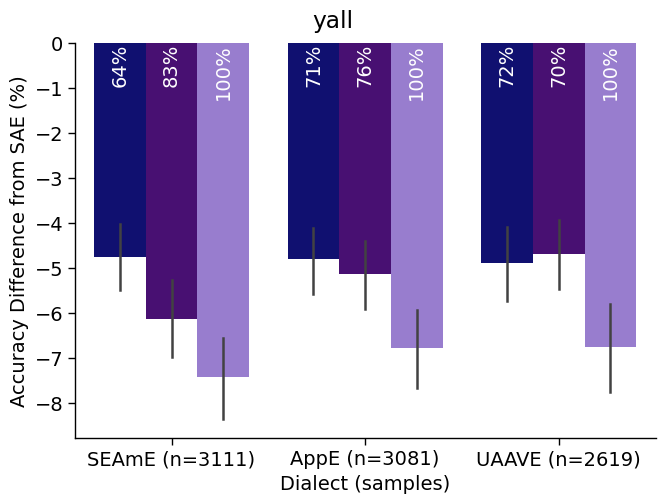

In [64]:
# Set the context with a specific font size
sns.set_context("paper", rc={"font.size": 14, "axes.titlesize": 14, "axes.labelsize": 14,
                                "xtick.labelsize": 14, "ytick.labelsize": 14, "legend.fontsize": 14, "legend.title_fontsize": 14}, )
                                

# dialect_order = ["ChcE", "AppE", "SEAmE", "UAAVE", "IndE", "CollSgE"]
rule_order = ["Rule of Interest", "Obligatory Dialect Rules", "All Dialect Rules"]
# rule_order = [rule_in_focus, "Obligatory Dialect Rules", "All Dialect Rules"]

longform_restricted_df_sae_corr = longform_restricted_df[longform_restricted_df["acc_orig"] == 1]

# Create mapping: "Dialect" -> "Dialect (n=X)"
count_mapper = longform_restricted_df_sae_corr.groupby("Dialect")["id"].count()//3
count_labels = {dialect: f"{dialect} (n={count})" for dialect, count in count_mapper.items()}

# Apply the new labels in the plotting DataFrame
longform_restricted_df_sae_corr["Dialect (samples)"] = longform_restricted_df_sae_corr["Dialect"].map(count_labels)
dialect_order = longform_restricted_df_sae_corr["Dialect (samples)"].unique()

# create proportion of all dialect rules as a pivot table
pivot_df = longform_restricted_df_sae_corr.pivot_table(
    index="Dialect (samples)",
    columns="Rules Used",
    values=acc_name
)

# Normalize: accuracy as % of All Dialect Rules
pivot_df = (pivot_df.div(pivot_df["All Dialect Rules"], axis=0) * 100).round(1)

rp = sns.catplot(
        longform_restricted_df_sae_corr, 
        kind="bar",
        y=acc_name, 
        x="Dialect (samples)", 
        hue="Rules Used",
        order=dialect_order,
        hue_order=rule_order,
        # palette={"Obligatory Dialect Rules": "darkblue", "All Dialect Rules": "skyblue"},
        palette = {
                'Rule of Interest': 'navy',
                # rule_in_focus: "navy",
                "Obligatory Dialect Rules": 'indigo',
                "All Dialect Rules": 'mediumpurple',
            },
        # errorbar=None,
        aspect=5.5/4,
        legend_out=False,
        legend=False,
    )

rp.fig.suptitle(rule_in_focus, y=1.01)

# Add base labels using precomputed pct_labels
for ax in rp.axes.flat:
    # bar_idx = 0
    for row_i, dialect in enumerate(dialect_order):
        for col_i, rule in enumerate(rule_order):
            bar = ax.containers[col_i][row_i]
            label = f"{pivot_df.loc[dialect, rule]:.0f}%"
            x = bar.get_x() + bar.get_width() / 2
            ax.text(x, -0.01, label, ha='center', va='top', fontsize=14, rotation=90, color='white')

In [ ]:
longform_restricted_df_sae_corr.groupby(["Dialect", "Rules Used"])["id"].count()

Rules Used,Dialect (samples),All Dialect Rules,Obligatory Dialect Rules,Rule of Interest,Obligatory Dialect Rules_pct_of_all,Rule of Interest_pct_of_all,All Dialect Rules_pct_of_all
0,AppE (n=2781),-0.100324,-0.085221,-0.085221,84.9,84.9,100.0
1,CollSgE (n=2925),-0.176410,-0.138462,-0.080000,78.5,45.3,100.0
2,UAAVE (n=2520),-0.125000,-0.089286,-0.082143,71.4,65.7,100.0


In [ ]:
# Set the context with a specific font size
sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12,
                                "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12})
                                

# dialect_order = ["ChcE", "AppE", "SEAmE", "UAAVE", "IndE", "CollSgE"]
rule_order = ["Rule of Interest", "Obligatory Dialect Rules", "All Dialect Rules"]
# rule_order = [rule_in_focus, "Obligatory Dialect Rules", "All Dialect Rules"]

# Create mapping: "Dialect" -> "Dialect (n=X)"
count_mapper = longform_restricted_df.groupby("Dialect")["id"].count() // 9
count_labels = {dialect: f"{dialect} (n={count})" for dialect, count in count_mapper.items()}

# Apply the new labels in the plotting DataFrame
longform_restricted_df["Dialect (samples)"] = longform_restricted_df["Dialect"].map(count_labels)

rp = sns.catplot(
        longform_restricted_df, 
        kind="bar",
        y=acc_name, 
        x="Dialect (samples)", 
        hue="Rules Used",
        # order=dialect_order,
        hue_order=rule_order,
        # palette={"Obligatory Dialect Rules": "darkblue", "All Dialect Rules": "skyblue"},
        palette = {
                'Rule of Interest': 'navy',
                # rule_in_focus: "navy",
                "Obligatory Dialect Rules": 'indigo',
                "All Dialect Rules": 'mediumpurple',
            },
        # errorbar=None,
        aspect=5.5/4,
        legend_out=False,
        # legend=False,
    )

rp.fig.suptitle(rule_in_focus, y=1.01)

## analyze by exclusion

In [175]:
filtered_dialect_combined_df = dialect_combined_df[~(dialect_combined_df["rules_executed_list"].apply(lambda l: len(l) == 0))]

rules_of_interest_dict = {
    "existential_it": ["AppE", "UAAVE", "CollSgE"], 
    "yall": ["SEAmE", "AppE", "UAAVE", ], 
    "drop_copula_be_NP": ["UAAVE", "CollSgE"],
    # "aint_be": ["SEAmE", "AppE", "UAAVE"], 
}

cols_to_keep = ["rules_executed_list", "acc_dialect","Accuracy Difference", "Dialect"]
id_cols = ["id", "dataset", "model"]

def get_dialect_without_rule(df, dialect, rule): 
    slice_df = df[df["Dialect"] == dialect]
    exclude_rule = slice_df[slice_df["rules_executed_list"].apply(lambda l: rule not in set(l))]
    return exclude_rule

excluding_slices = [] 
# for rule_in_focus, dialects in rules_of_interest_dict.items():
for d in dialects: 
    rule_slice = rule_combined_df[rule_combined_df["rule_transform"] == rule_in_focus].copy()
    rule_slice["Data Portion"] = "Rule Applied"
    rule_slice["Dialect"] = d
    dialect_exclude_slice = get_dialect_without_rule(filtered_dialect_combined_df, d, rule_in_focus)
    dialect_exclude_slice["Data Portion"] = "Other Dialect Rules (exclusive)"
    oblig_exclude_slice = get_dialect_without_rule(dialect_oblig_combined_df, d, rule_in_focus)
    oblig_exclude_slice["Data Portion"] = "Other Obligatory Rules (exclusive)"
    excluding_slice = pd.concat([rule_slice, oblig_exclude_slice, dialect_exclude_slice])
    excluding_slice["Rule"] = rule_in_focus
    excluding_slices.append(excluding_slice)

excluding_df = pd.concat(excluding_slices)

In [178]:
len(rule_slice)//3

1377

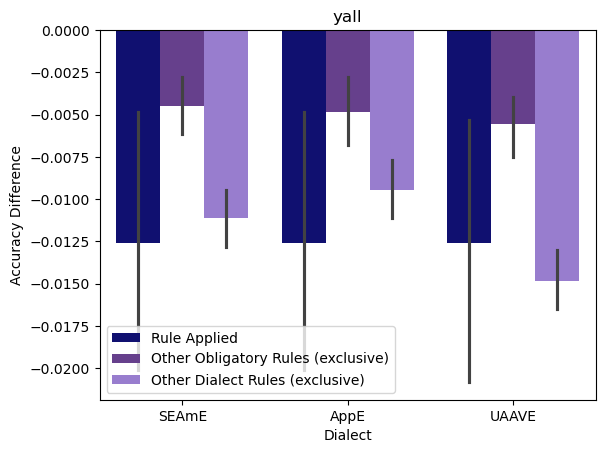

In [176]:
sns.barplot(excluding_df, x="Dialect", y="Accuracy Difference", hue="Data Portion", 
            # errorbar=None,
            palette = {
                'Rule Applied': 'navy',
                'Other Obligatory Rules (exclusive)': 'rebeccapurple',
                'Other Dialect Rules (exclusive)': 'mediumpurple',
            })
plt.title(rule_in_focus)
plt.legend(loc="lower left")

# singaporean cumulative analysis 

In [346]:
import jsonlines 

df_list = []

for model in model_mapping: 
    for dataset in datasets: 
        print(model, dataset)
        if dataset == "mmlu": 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            pairs_log_path = base_path + f"{dataset}/pair_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples*.jsonl"

            pair_df = load_files_matching(pairs_log_path)
            subset_df = load_files_matching(subset_log_path)
             # rules_df = load_files_matching(rules_log_path)
        else: 
            subset_log_path = base_path + f"{dataset}/original_subset/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            pairs_log_path = base_path + f"{dataset}/pair_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            # rules_log_path = base_path + f"{dataset}/A_transforms/lm_eval_results/{model_mapping[model]}/samples.jsonl"
            
            subset_df = pd.read_json(subset_log_path, lines=True)
            pair_df = pd.read_json(pairs_log_path, lines=True)
            # rules_df = pd.read_json(rules_log_path, lines=True)

        combined_df = combine_orig_and_transform(subset_df, pair_df, model=model, transform_suffix="pair", rules_executed=True)
        combined_df["dataset"] = dataset
        combined_df["model"] = model 
        df_list.append(combined_df)

pair_combined_df = pd.concat(df_list)

gpt4o-mini boolq
exact_match
gpt4o-mini mmlu
exact_match
gpt4o-mini sciq
exact_match
gemma boolq
acc
gemma mmlu
acc
gemma sciq
acc
mistral-7b boolq
acc
mistral-7b mmlu
acc
mistral-7b sciq
acc


In [347]:
pair_combined_df["rule_transform"].unique()

array(['null_prepositions+drop_copula_be_NP',
       'null_prepositions+one_relativizer',
       'null_prepositions+one_relativizer+drop_copula_be_NP'],
      dtype=object)

In [348]:
rules_considered = ["null_prepositions", "drop_copula_be_NP", "one_relativizer"]
singe_rules_df = rule_combined_df[rule_combined_df["rule_transform"].isin(rules_considered)]

trio = "null_prepositions+one_relativizer+drop_copula_be_NP"
duo = "null_prepositions+one_relativizer"
duo2 = "null_prepositions+drop_copula_be_NP"
single = "null_prepositions"

single_rule_df = singe_rules_df[singe_rules_df["rule_transform"] == single]
two_rule_df = pair_combined_df[pair_combined_df["rule_transform"] == duo]
three_rule_df = pair_combined_df[pair_combined_df["rule_transform"] == trio]



In [349]:
id_cols = ["id", "dataset", "model"]
cols_to_keep = ["Accuracy Difference"]

def get_matching_rows(df, reference_df):
    matching_indices = df.set_index(['id', 'dataset', 'model']).index.isin(
        reference_df.set_index(['id', 'dataset', 'model']).index
    )
    return df[matching_indices]

# pair1_slice = pair_combined_df[pair_combined_df["rule_transform"] == duo]
# pair1_df = get_matching_rows(pair1_slice, three_rule_df)

# pair2_slice = pair_combined_df[pair_combined_df["rule_transform"] == duo2]
# pair2_df = pair_combined_df[pair_combined_df["rule_transform"] == duo2]

matching_id_pair_df = get_matching_rows(pair_combined_df, three_rule_df)

matching_id_rule_df = get_matching_rows(singe_rules_df, three_rule_df)





In [350]:
trio_subset_all_rules = pd.concat([matching_id_rule_df, matching_id_pair_df])

In [351]:
trio_subset_all_rules

,id,transformed_text,rule_transform,acc_rule,orig_question,acc_orig,Accuracy Difference,dataset,model,rules_executed_list,acc_pair
23485,13,calcium carbide cac2 is the raw material the p...,null_prepositions,1.0,calcium carbide cac2 is the raw material for t...,1,0,boolq,gpt4o-mini,NaN,NaN
23515,54,is sanskrit the first language the world,null_prepositions,1.0,is sanskrit the first language of the world,1,0,boolq,gpt4o-mini,NaN,NaN
23531,78,is porto rico a part the united states,null_prepositions,1.0,is porto rico a part of the united states,1,0,boolq,gpt4o-mini,NaN,NaN
23589,159,is dc legends tomorrow a comic,null_prepositions,1.0,is dc legends of tomorrow based on a comic,0,1,boolq,gpt4o-mini,NaN,NaN
23595,165,is antioch part the bay area,null_prepositions,1.0,is antioch ca part of the bay area,1,0,boolq,gpt4o-mini,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6081,11529,The curie ci one () one measure the rate what?,null_prepositions+one_relativizer+drop_copula_...,NaN,The curie (ci) is one measure of the rate of w...,1,0,sciq,mistral-7b,"[drop_copula_be_NP, one_relativizer, one_relat...",1.0
6082,11538,Wetlands one environments which the soil is ei...,null_prepositions+one_relativizer+drop_copula_...,NaN,Wetlands are environments in which the soil is...,1,0,sciq,mistral-7b,"[drop_copula_be_NP, one_relativizer, null_prep...",1.0
6083,11557,"When amino acids bind together, they one form ...",null_prepositions+one_relativizer+drop_copula_...,NaN,"When amino acids bind together, they form a lo...",1,0,sciq,mistral-7b,"[one_relativizer, null_prepositions, drop_copu...",1.0
6084,11605,"Biochemical compounds include sugars one , sta...",null_prepositions+one_relativizer+drop_copula_...,NaN,"Biochemical compounds that include sugars, sta...",1,0,sciq,mistral-7b,"[one_relativizer, one_relativizer, one_relativ...",1.0


In [356]:
trio_sae_corr = trio_subset_all_rules[trio_subset_all_rules["acc_orig"] == 1]

accuracy_diff_means_sae_corr = trio_sae_corr.groupby("rule_transform")["Accuracy Difference"].mean().reset_index()

In [357]:
accuracy_diff_means_sae_corr.to_csv("data/singe_cumulative_analysis_sae_corr.csv", index=False)

In [352]:
accuracy_diff_means = trio_subset_all_rules.groupby("rule_transform")["Accuracy Difference"].mean().reset_index()


# sample size = 1484 questions, answered by each ML model 

In [353]:
accuracy_diff_means

,rule_transform,Accuracy Difference
0,drop_copula_be_NP,-0.003369
1,null_prepositions,-0.004942
2,null_prepositions+drop_copula_be_NP,-0.014376
3,null_prepositions+one_relativizer,-0.011006
4,null_prepositions+one_relativizer+drop_copula_...,-0.019991
5,one_relativizer,-0.003819


In [41]:
accuracy_diff_means.to_csv("data/singe_cumulative_analysis.csv", index=False)

<Axes: xlabel='Accuracy Difference', ylabel='rule_transform'>

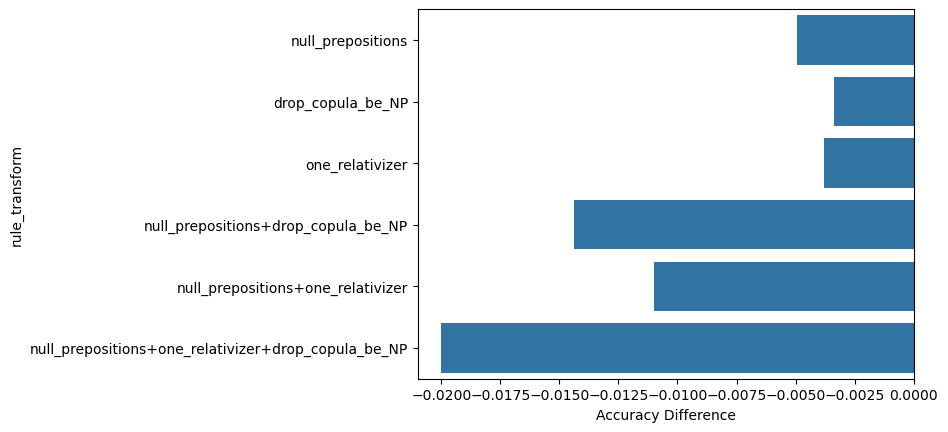

In [35]:
sns.barplot(data=trio_subset_all_rules, y="rule_transform", x="Accuracy Difference",errorbar=None,)

In [ ]:
cols_to_keep = ["transformed_text_dialect", "rules_executed_list_dialect", "transformed_text_dialect_oblig", "rules_executed_list_dialect_oblig", "acc_dialect","acc_dialect_oblig", "Dialect"]
id_cols = ["id", "dataset", "model"]

restricted_slices = [] 

for d, rule in most_consequential_rule.items(): 
    rule_slice = rule_combined_df[rule_combined_df["rule_transform"] == rule]
    oblig_slice = oblig_and_full_df[oblig_and_full_df["Dialect"] == d]
    restricted_slice = rule_slice.merge(oblig_slice[cols_to_keep + id_cols], on=id_cols)
    restricted_slices.append(restricted_slice)


restricted_df = pd.concat(restricted_slices)

In [ ]:
restricted_cumulative_df
sns.barplot(restricted_cumulative_df, y="rule_transform", x="Accuracy Difference")

<Axes: xlabel='Accuracy Difference', ylabel='rule_transform'>

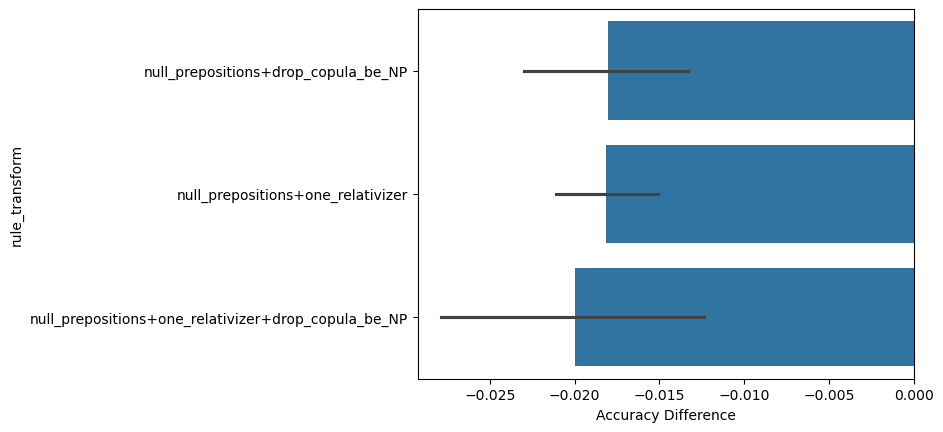

In [12]:
sns.barplot(pair_combined_df, y="rule_transform", x="Accuracy Difference")

<Axes: xlabel='Accuracy Difference', ylabel='rule_transform'>

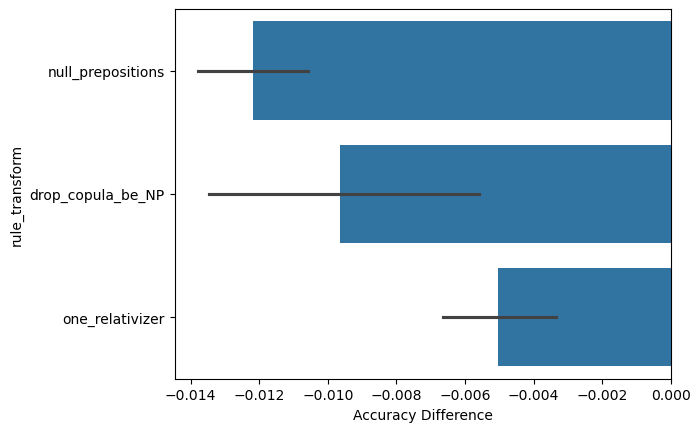

In [13]:
sns.barplot(singe_rules_df, y="rule_transform", x="Accuracy Difference")